# Numerical Simulation of Physical Systems - The Damped Harmonic Oscillator

Edward Alexandroff <br> 
April 2021

In this notebook, the motion of a damped driven harmonic oscillator is simulated numerically, first for cases where the solution can be found analytically, and then for cases where no such solution exists. Here a "damped driven harmonic oscillator" could be referring to, for example, a mass bouncing on a spring experiencing both air resistance (damped) and some force parallel to its motion (driven). This Jupyer notebook was first produced as a piece of coursework for the Computational Physics module PHYS20762.

## Initializing the Notebook

First, let's initialize the notebook:

In [126]:
import numpy as np
import cmath
import matplotlib.pyplot as plt
from scipy import signal

## 1. The Damped Harmonic Oscillator

Before investigating the damped, driven harmonic oscillator (DDHO), the simpler case of the damped harmonic oscillator (DHO) can first be considered. The equation of motion for this system is 

$$ma(t) = -bv(t) - kx(t)$$ 

where $b$ is the damping constant and $k$ is the spring constant. a, v, and x refer to acceleration, velocity, and position respectively. In this section of the notebook, a number of numerical methods will be used to solve this ODE. These solutions will then be compared with the analytical solution to determine thier accuracy. The above ODE is subject to the following initial conditions and physical parameters:

In [127]:
x0 = 0 #initial position, m
v0 = -1 #initial velocity, ms^-1

M = 5.25 #mass, kg
K = 2.75 #spring constant, kgs^-2

### The Analytic Solution

It's worth studying the DHO first because the general analytic solution can be found and used to judge the accuracy of all numerical methods considered. The analytic solution can be implemented as follows:

In [128]:
def Analytic(time, m, k, b):
    """
    Function that calculates the analytic solution for the DHO (i.e. gives values for x and v at regular intervals within the
    specificed duration).
    
    Arguments:
        time (np array of floats)
    Returns:
        analytic_results (np array of floats)
    """
    # Constants
    omega = cmath.sqrt(4 * k * m - b ** 2) / (2 * m) #the angular frequency of the DHO
    A = (b / (4 * 1j * m * omega + 1/2)) * x0 + (m / (2 * m * omega * 1j)) * v0
    B = x0 - A
    
    # The analytic solution when b is not b_cr
    x = np.exp(-b * time / (2 * m)) * (A * np.exp(1j * omega * time) + B * np.exp(-1j * omega * time))
    v = (-b / (2 * m)) * x + (1j * omega * np.exp((-b * time) / (2 * m)) * 
                              (A * np.exp(1j * omega * time) - B * np.exp(-1j * omega * time)))
    
    analytic_values = np.array([x.real, v.real])
    return analytic_values

### The Euler Method

The Euler method is as follows:
 
$$x_{i+1} = x_{i} + h \cdot v_{i}$$ 
$$v_{i+1} = v_{i} + h \cdot a_{i}$$    
where  
$$a_{i} = -\frac{k}{m} x_{i} -\frac{b}{m} v_{i}$$

$i$ is the step-number and $h$ is the small time step between these steps. We can use this to model the system between times $t =0$ and $t=T$. This method can be implemented as follows:

In [129]:
def Euler(m, k, b, h):
    """
    Uses the Euler method as detailed above to calculate the x and v values at regular time steps
    
    Arguments:
        m (float)
        k (float)
        b (float)
        h (float)
    Returns:
        euler_values (np array)
    """
    nsteps = int(T/h)
    
    x = np.zeros(nsteps)
    v = np.zeros(nsteps)
    x[0] = x0
    v[0] = v0

    for i in range(nsteps - 1):
        
        #calculating the acceleration
        a = -(k / m) * x[i] - (b / m) * v[i]
    
        #calculate x and v at step i+1 based off thier values in step i
        x[i + 1] = x[i] + v[i] * h
        v[i + 1] = v[i] + a * h
        
    euler_values = np.array([x, v])
    return euler_values

### The Improved Euler Method

The improved euler method is essentially just the euler method but with an extra term included in the expansion of $x(t+h)$.

$$x_{i+1} = x_{i} + h \cdot v_{i} + \frac{h^2}{2} \cdot a_i $$ 
$$v_{i+1} = v_{i} + h \cdot a_{i}$$    
where  
$$a_{i} = -\frac{k}{m} x_{i} -\frac{b}{m} v_{i}$$

It can be implemented as follows:

In [130]:
def Impr_Euler(m, k, b, h):
    """ 
    Uses the improved Euler method as detailed above to calculate the x and v values at regular time steps
    
    Arguments:
        m (float)
        k (float)
        b (float)
        h (float)
    Returns:
        impr_euler_values (np array)
    """
    nsteps = int(T/h)
    
    x = np.zeros(nsteps)
    v = np.zeros(nsteps)
    x[0] = x0
    v[0] = v0

    for i in range(nsteps - 1):
        
        #calculating the acceleration
        a = -(k / m) * x[i] - (b / m) * v[i]
    
        #calculate x and v at step i+1 based off thier values in step i
        x[i + 1] = x[i] + v[i] * h + ((a * h ** 2) / 2) 
        v[i + 1] = v[i] + a * h
        
    impr_euler_values = np.array([x, v])
    return impr_euler_values

### The Verlet Method

The Verlet method makes use of a central derivative and third order expansions of $x(t+h)$. This method gives

$$x_{i+1} = Ax_{i} + Bx_{i-1}$$  
$$v_i = \frac{x_{i+1} - x_{i-1}}{2h}$$

where

$$A = 2 \left(\frac{2m-kh^2}{D}\right),\ B = \frac{bh-2m}{D},\ D = 2m + bh$$

It should be noted that the Verlet method requires the $ith$ and $(i-1)th$ terms in order to calculate the $(i+1)th$ term. Hence, the first step after the initial conditions is calculated using the improved euler method and then the Verlet method is used for all subsequent iterations. 

In [131]:
def Verlet(m, k, b, h):
    """
    Uses the Verlet method as detailed above to calculate the x and v values at regular time steps
    
    Arguments:
        m (float)
        k (float)
        b (float)
        h (float)
    Returns:
        verlet_values (np array)
    """
    nsteps = int(T/h)
    
    #constants
    D = 2 * m + b * h
    A = 2 * (2 * m - k * h ** 2) / D
    B = (b * h - 2 * m) / D
    
    x = np.zeros(nsteps)
    v = np.zeros(nsteps)
    x[0] = x0
    v[0] = v0
    
    #using the improved euler method to calculate the first iteration
    a = -(k / m) * x[0] - (b / m) * v[0]
    x[1] = x[0] + v[0] * h + ((a * h ** 2) / 2)
    v[1] = v[0] + a * h
   
    #iterating through x and v values as described above
    for i in range(1, nsteps - 1):
        
        x[i + 1] = A * x[i] + B * x[i - 1]
        v[i] = (x[i + 1] - x[i - 1]) / (2 * h)
        
    verlet_values = np.array([x, v])
    return verlet_values

### The Euler-Cromer Method

The Euler-Cromer method is similar to Euler's method except that a $v_{i}$ in the recursion relation for $x_{i+1}$ is replaced with a $v_{i+1}$. It can be written out as

$$x_{i+1} = x_{i} + h \cdot v_{i+1}$$ 
$$v_{i+1} = v_{i} + h \cdot a_{i}$$    
where  
$$a_{i} = -\frac{k}{m} x_{i} -\frac{b}{m} v_{i}$$

It can be implemented as follows:

In [132]:
def Euler_Cromer(m, k, b, h):
    """
    Uses the Euler-Cromer method as detailed above to calculate the x and v values at regular time steps
    
    Arguments:
        m (float)
        k (float)
        b (float)
        h (float)
    Returns:
        euler_cromer_values (np array)
    """
    nsteps = int(T/h)
    
    x = np.zeros(nsteps)
    v = np.zeros(nsteps)
    x[0] = x0
    v[0] = v0

    for i in range(nsteps - 1):
        
        #calculating the acceleration
        a = -(k / m) * x[i] - (b / m) * v[i]
    
        #calculate x and v at step i+1 based off thier values in step i
        v[i + 1] = v[i] + a * h
        x[i + 1] = x[i] + v[i+1] * h
        
    euler_cromer_values = np.array([x, v])
    return euler_cromer_values

### Results

Now, let's plot every method as well as the analytical solution. This has been done below for the case of both heavy and light damping using a step size of 0.2 s (with initial conditions given at the beginning of the notebook)

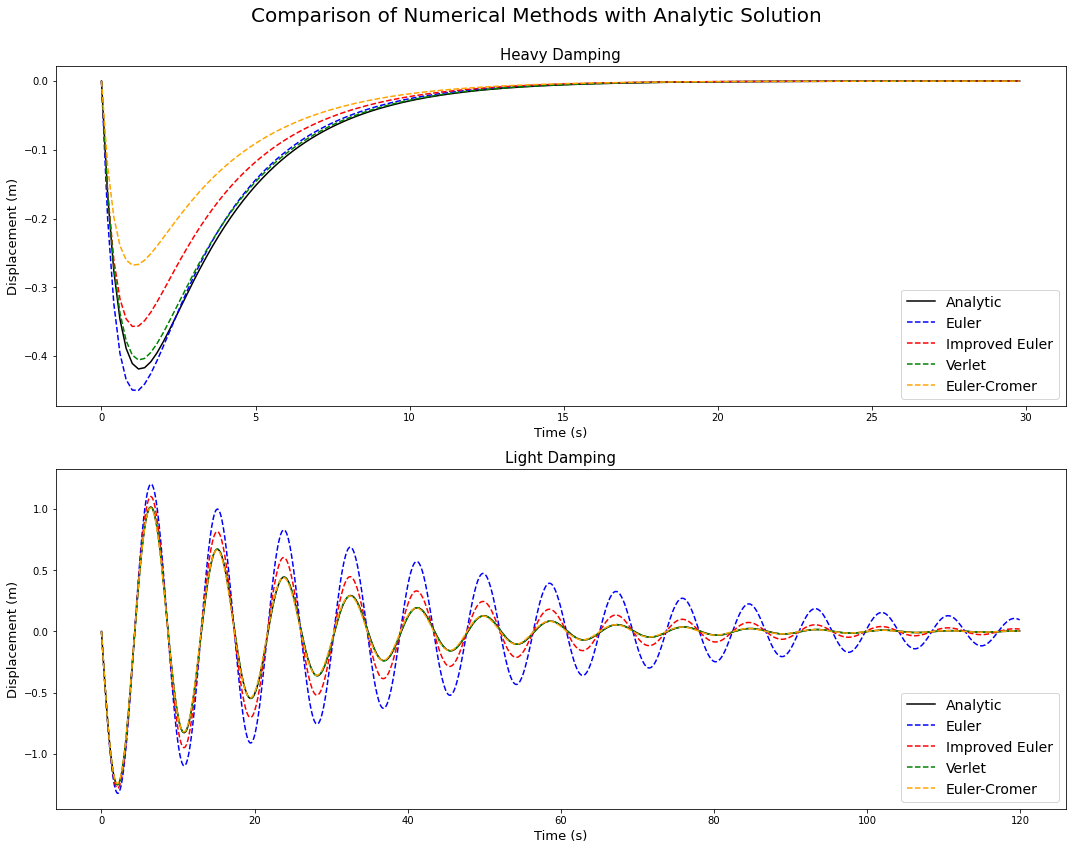

In [133]:
#setting up figure
plt.rcParams["figure.figsize"] = (15, 12)
figure = plt.figure()
figure.suptitle(r'Comparison of Numerical Methods with Analytic Solution', fontsize=20)

#Heavily Damped Subplot:

#setting more physical parameters as well as parameters for the numerical methods
B_heavy = 10 #damping constant, kgs^-1
T = 30 #duration, s
H = 0.2 #step size, s
time_values = np.arange(0, T, H)

#setting up the actual subplot
heavily_damped_plot = figure.add_subplot(211)
heavily_damped_plot.set_title('\nHeavy Damping', fontsize=15)
heavily_damped_plot.set_xlabel(r'Time (s)', fontsize=13)
heavily_damped_plot.set_ylabel(r'Displacement (m)', fontsize=13)

#plotting the different methods
analytic_plot = heavily_damped_plot.plot(time_values, Analytic(time_values, M, K, B_heavy)[0], color='black', label='Analytic')
euler_plot = heavily_damped_plot.plot(time_values, Euler(M, K, B_heavy, H)[0], 'k--', color='blue', label='Euler')
impr_euler_plot = heavily_damped_plot.plot(time_values, Impr_Euler(M, K, B_heavy, H)[0], 'k--', color='red', label='Improved Euler')
verlet_plot = heavily_damped_plot.plot(time_values, Verlet(M, K, B_heavy, H)[0], 'k--', color='green', label='Verlet')
euler_cromer_plot = heavily_damped_plot.plot(time_values, Euler_Cromer(M, K, B_heavy, H)[0], 'k--', color='orange', 
                                             label='Euler-Cromer')

heavily_damped_plot.legend(loc="lower right", fontsize=14)

#Lightly Damped Subplot:

#setting more physical parameters as well as parameters for the numerical methods
B_light = 0.5 #damping constant, kgs^-1
T = 120 #duration, s
H = 0.1 #step size, s
time_values = np.arange(0, T, H)

#setting up the actual subplot
lightly_damped_plot = figure.add_subplot(212)
lightly_damped_plot.set_title('Light Damping', fontsize=15)
lightly_damped_plot.set_xlabel(r'Time (s)', fontsize=13)
lightly_damped_plot.set_ylabel(r'Displacement (m)', fontsize=13)

#plotting the different methods
analytic_plot = lightly_damped_plot.plot(time_values, Analytic(time_values, M, K, B_light)[0], color='black', label='Analytic')
euler_plot = lightly_damped_plot.plot(time_values, Euler(M, K, B_light, H)[0], 'k--', color='blue', label='Euler')
impr_euler_plot = lightly_damped_plot.plot(time_values, Impr_Euler(M, K, B_light, H)[0], 'k--', color='red', label='Improved Euler')
verlet_plot = lightly_damped_plot.plot(time_values, Verlet(M, K, B_light, H)[0], 'k--', color='green', label='Verlet')
euler_cromer_plot = lightly_damped_plot.plot(time_values, Euler_Cromer(M, K, B_light, H)[0], 'k--', color='orange', 
                                             label='Euler-Cromer')

legend = lightly_damped_plot.legend(loc="lower right", fontsize=14)
plt.tight_layout()

### Effect of Choice of Time Step

As can be seen in the plots above, all of the numerical methods deviate from the analytic solution to differing extents (albeit perhaps not all visibly for all choices of $h$ and $b$). In this section of the notebook, we investigate the effect of choice of time step on the accuracy of each method by considering the energy of the oscillator. The energy of the system is given by

$$E(t) = \frac{1}{2} kx^{2}(t) + \frac{1}{2} mv^{2}(t)$$

Using this expression, at every time step, the energy of the analytic solutions and the energy of the numerical methods can be calculated. The deviation of the energy of a given method from the analytic energy over some time period can be used to determine the accuracy of that method. This deviation has been quantified through the average
fractional error, $\sigma_{fractional}$

$$\sigma_{fractional} = \frac{1}{N}\sum\limits_{n\,=\,0}^{N}\frac{\left(\lvert E_{analytic} - E_{method} \rvert\right)}{E_{analytic}}$$

where $E_{analytic}$ and $E_{method}$ are the energies at a given timestep $n$ for the analytic solution and a given numerical method respectively. $N$ is the final time step, corresponding with $t=T$. Below, plots of $\sigma_{fractional}$ as a function of $h$ for each method are produced. The two plots are for the first ten seconds of the heavily and lightly damped examples above. Only the first ten seconds are considered because the following code slows down significantly as the duration, $T$, is increased. The first ten seconds are where most of the deviation in position appears to be taking place (as can be seen in the plots above), and so it would be logical to expect the greatest deviation in energy here as well. 

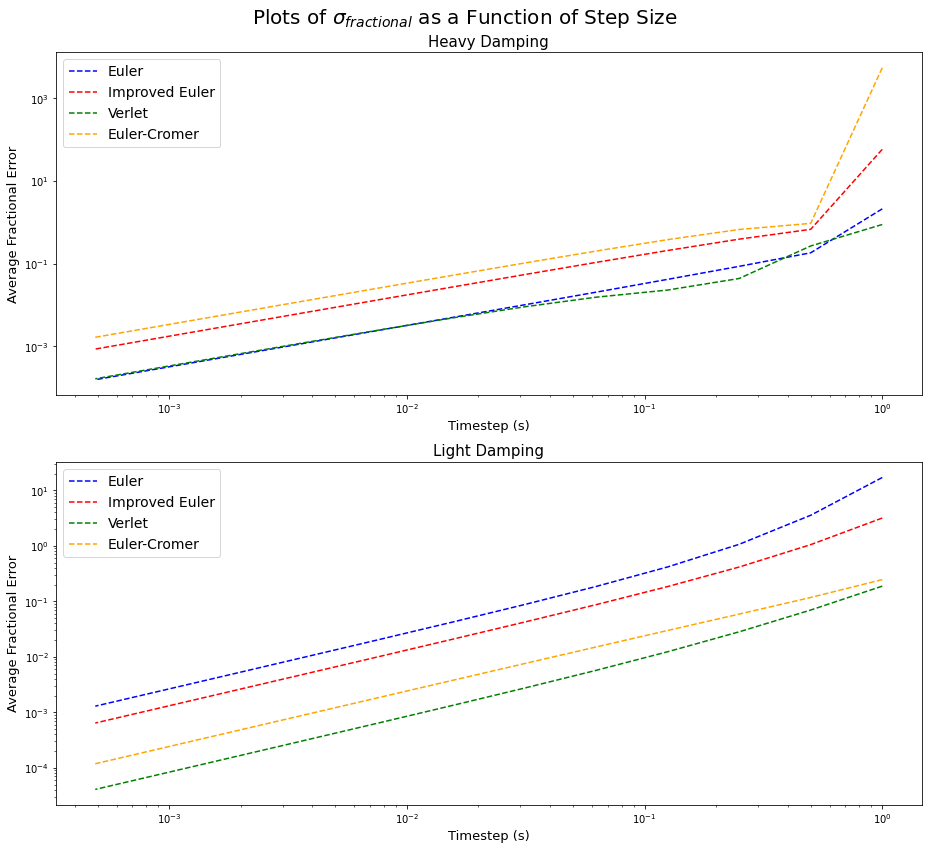

In [134]:
#setting a physical parameter as well as parameters for the numerical methods
T = 10 #duration, s
NUM_H_VALUES = 12 #the number of h values plotted
H_MAX = 1 #maximum h-value plotted, s

def analytic_energy(time, b):
    """
    Function that calculates the energy of the analytic solution at all time steps within the duration using the equation 
    above. The analytic solution function needs it's own energy function since it works differently from the numerical method 
    functions, i.e. h vs time arguments
    
    Arguments:
        time (np array)
        b (float)
    Returns:
        analytic_E (np array)
    """
    x = Analytic(time, M, K, b)[0]
    v = Analytic(time, M, K, b)[1]
    
    analytic_E = (1 / 2) * ((K * x ** 2) + (M * v ** 2))
    
    return analytic_E
    
def method_energy(method, h, b):
    """
    Function that gives the energy of a given numerical method at all time steps within the duration using the equation above.
    
    Arguments:
        method (function)
        h (float)
        b (float)
    Returns:
        method_E (np array)
    """
    x = method(M, K, b, h)[0]
    v = method(M, K, b, h)[1]
    
    method_E = (1 / 2) * ((K * x ** 2) + (M * v ** 2))
    
    return method_E

def frac_error(method, duration, h, b):
    """
    Calculates the average fractional error as described above.
    
    Arguments:
        method (function)
        duration (float or int)
        h (float)
        b (float)
    Returns:
        frac_error (float)
    """
   
    #using linspace instead of arange due to np.arange being inconsistent for float values of step 
    nsteps = int(T/h)
    time_values = np.linspace(0, duration, num=nsteps)
    
    analytic_E = analytic_energy(time_values, b)
    method_E = method_energy(method, h, b)
    
    #caclcuating the average fractional of a given method relative to the analytic solution
    E_difference = np.absolute(analytic_E - method_E)
    frac_error =  np.sum(E_difference / analytic_E) / nsteps
    
    return frac_error

def error_func(nvalues, h_max, method, b):
    """
    Given nvalues, the number of h values required, and h_max, the maximum h_value required, returns the array of h values 
    as well as the associated array of average fractional error values for a given method. The h values are calculated by 
    repeatedly dividing the max h value by 2 to ensure a regular spacing of points on a logarithmic plot, unlike e.g. 
    np.linspace would produce.
    
    Arguments:
        nvalues (int)
        h_max (int or float)
        method (function)
        b (float)
    Returns:
        h_values (np array)
        frac_error_values (np array)
    """
    #calculating h values
    h_values = np.zeros(nvalues)
    h_values[0] = h_max
    for i in range(nvalues - 1):
        h_values[i + 1] = h_values[i] / 2
    
    #calulating average fractional error values
    frac_error_values = np.zeros(nvalues)
    for i in range(nvalues):
        frac_error_values[i] = frac_error(method, T, h_values[i], b)
        
    return h_values, frac_error_values

#Making the plots:

#setting up the plot
plt.rcParams["figure.figsize"] = (13, 12)
figure = plt.figure()
figure.suptitle('Plots of $\sigma_{fractional}$ as a Function of Step Size', fontsize=20)

#Heavy Damping subplot:

#setting up the subplot for the heavily damped case
heavily_damped_E_plot = figure.add_subplot(211)
heavily_damped_E_plot.set_title('Heavy Damping', fontsize=15)
heavily_damped_E_plot.set_xlabel(r'Timestep (s)', fontsize=13)
heavily_damped_E_plot.set_ylabel(r'Average Fractional Error', fontsize=13)

#plotting the different methods for the heavily damped case
euler_E_plot = heavily_damped_E_plot.loglog(error_func(NUM_H_VALUES, H_MAX, Euler, B_heavy)[0], 
                                            error_func(NUM_H_VALUES, H_MAX, Euler, B_heavy)[1], 'k--', color='blue', 
                                            label='Euler')
impr_euler_E_plot = heavily_damped_E_plot.loglog(error_func(NUM_H_VALUES, H_MAX, Impr_Euler, B_heavy)[0], 
                                                 error_func(NUM_H_VALUES, H_MAX, Impr_Euler, B_heavy)[1], 'k--', 
                                                 color='red', label='Improved Euler')
verlet_E_plot = heavily_damped_E_plot.loglog(error_func(NUM_H_VALUES, H_MAX, Verlet, B_heavy)[0], 
                                             error_func(NUM_H_VALUES, H_MAX, Verlet, B_heavy)[1], 'k--', color='green', 
                                             label='Verlet')
euler_cromer_plot = heavily_damped_E_plot.loglog(error_func(NUM_H_VALUES, H_MAX, Euler_Cromer, B_heavy)[0], 
                                                 error_func(NUM_H_VALUES, H_MAX, Euler_Cromer, B_heavy)[1], 'k--', 
                                                 color='orange', label='Euler-Cromer')

legend = heavily_damped_E_plot.legend(loc="upper left", fontsize=14)

#Light Damping subplot:

#setting up the subplot for the lightly damped case
lightly_damped_E_plot = figure.add_subplot(212)
lightly_damped_E_plot.set_title('Light Damping', fontsize=15)
lightly_damped_E_plot.set_xlabel(r'Timestep (s)', fontsize=13)
lightly_damped_E_plot.set_ylabel(r'Average Fractional Error', fontsize=13)

#plotting the different methods for the lightly damped case
euler_E_plot = lightly_damped_E_plot.loglog(error_func(NUM_H_VALUES, H_MAX, Euler, B_light)[0], 
                                            error_func(NUM_H_VALUES, H_MAX, Euler, B_light)[1], 'k--', color='blue', 
                                            label='Euler')
impr_euler_E_plot = lightly_damped_E_plot.loglog(error_func(NUM_H_VALUES, H_MAX, Impr_Euler, B_light)[0], 
                                                 error_func(NUM_H_VALUES, H_MAX, Impr_Euler, B_light)[1], 'k--', 
                                                 color='red', label='Improved Euler')
verlet_E_plot = lightly_damped_E_plot.loglog(error_func(NUM_H_VALUES, H_MAX, Verlet, B_light)[0], 
                                             error_func(NUM_H_VALUES, H_MAX, Verlet, B_light)[1], 'k--', color='green', 
                                             label='Verlet')
euler_cromer_plot = lightly_damped_E_plot.loglog(error_func(NUM_H_VALUES, H_MAX, Euler_Cromer, B_light)[0], 
                                                 error_func(NUM_H_VALUES, H_MAX, Euler_Cromer, B_light)[1], 'k--', 
                                                 color='orange', 
                                                 label='Euler-Cromer')

legend = lightly_damped_E_plot.legend(loc="upper left", fontsize=14)
plt.tight_layout()

From the plots, we can seen that all methods decreases with $h$. Qualitatively, the Verlet method appears to be the most accurate method for both scenarios. Nontheless, let's quantitatively determine the best method, as well as the step-size at which it's suitably accurate. In the code below, if a certain method produces a value of $\sigma_{fractional}$ below a given accuracy value for the given range of h values, this value is plotted on the above plots. The value of this "best error" as well as the step size required to reach it are displayed on the plots. Again, this is done for the cases of both light and heavy damping

The accuracy was chosen to be 0.0005 for both cases. This is because judging from the graphs above, this looks like one of the lowest values of $\sigma_{fractional}$ that will still intersect curves on both plots (for our given range of h values)

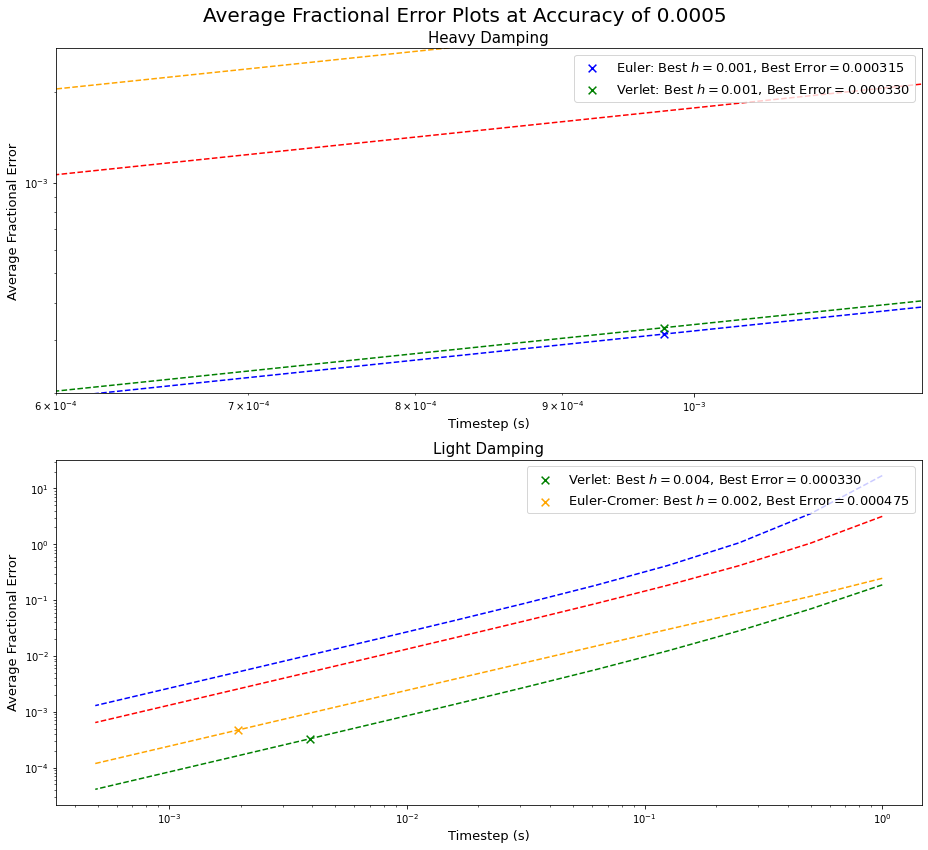

In [135]:
#setting the required accuracy
ACCURACY = 0.0005

def accuracy_func(n_values, h_max, method, b, accuracy):
    """
    Function determines whether or not a given method ever produces a value of average fractional error smaller than the 
    desired accuracy value (for the range of h values provided). This range of h values is determined by n_values and h_max
    in the error_func function. If so, it outputs that error value and the associated step size. If not, it terminates, and 
    gives the error value nearest the desired accuracy as well as its associated h value. This achievement of the required
    accuracy is given by the state of the boolean accuracy_reached variable
    
    Arguments:
        n_values (int)
        h_max (float or int)
        method (function)
        b (float or int)
        accuracy (float or int)
    Returns:
        h_values[i] or [i - 1] (float)
        frac_error_values[i] or [i - 1] (float)
        accuracy_reached (boolean)
    """
    #"unpacking" the outputs of the error_func function
    h_values, frac_error_values = error_func(n_values, h_max, method, b)
    
    #starting a counter
    i = 0
    
    #ensuring that the function stops checking error values when it runs out of values to check before it finds a value
    #below the required accuracy. This avoids an index error
    while i < n_values: 
        
        #checking if the error value is smaller than the accuracy
        if frac_error_values[i] <= accuracy:
            
            #if so, set accuracy_reached to True and stop the function. Return the first error value below the required 
            #accuracy and associated h

            accuracy_reached = True
            return h_values[i], frac_error_values[i], accuracy_reached
            
        else:
            #if not, check the next value by increasing the counter by 1
            i += 1
            
    #if the function does run out of values to check, set accuracy_reached to False. Return the nearest error and 
    #associated h value
    accuracy_reached = False    
    return h_values[i - 1], frac_error_values[i - 1], accuracy_reached

def accuracy_points(b, accuracy, plot):
    """
    For methods that do give an error value below the required accuracy, plots a point on the respective h vs error curve
    at the first error values below the accuracy. Generates a legend that contains its coordinates.
    
    Arguments:
        b (float)
        accuracy (float)
        plot (plt subplot)
    """
    #writing out all the methods, their names, and their associated colors
    methods = [Euler, Impr_Euler, Verlet, Euler_Cromer]
    method_names =['Euler', 'Improved Euler', 'Verlet', 'Euler-Cromer']
    method_colors = ['blue', 'red', 'green', 'orange']
    
    #for all methods:
    for i in range(len(methods)):
        
        #"unpacking" the results of the accuracy function
        best_values = accuracy_func(NUM_H_VALUES, H_MAX, methods[i], b, accuracy)
        best_h = best_values[0]
        best_error = best_values[1]
        
        #adding the coordinates of the point on the h-sigma-plane so that the legend contains all information needed 
        #(see below)
        method_label = method_names[i] + ': Best $h=${:.3f}, Best Error$=${:.6f}'.format(best_h, best_error)
        
        #if the method does produce an error value below the required accuracy:
        if best_values[2] == True:
            
            #plot a scatterpoint on the curve at this error value. Point is same color as the curve
            plot.scatter(best_h, best_error,  s=60, color=method_colors[i], marker='x', 
                         label=method_label)
            
    #generates a legend as well       
    plot.legend(loc="upper right", fontsize=13)
    
    return

#Making the plots:

#setting up the plot
plt.rcParams["figure.figsize"] = (13, 12)
figure = plt.figure()
figure.suptitle('Average Fractional Error Plots at Accuracy of {}'.format(ACCURACY), fontsize=20)

#Heavy Damping subplot:

#setting up the subplot for the heavily damped case
heavily_damped_E_plot = figure.add_subplot(211)
heavily_damped_E_plot.set_title('Heavy Damping', fontsize=15)
heavily_damped_E_plot.set_xlabel(r'Timestep (s)', fontsize=13)
heavily_damped_E_plot.set_ylabel(r'Average Fractional Error', fontsize=13)
#changing x and y axis limits so can tell the two points apart
heavily_damped_E_plot.set_ylim([0.0002, 0.0028])
heavily_damped_E_plot.set_xlim([0.0006, 0.0012])

#plotting the different methods for the heavily damped case
euler_E_plot = heavily_damped_E_plot.loglog(error_func(NUM_H_VALUES, H_MAX, Euler, B_heavy)[0], 
                                            error_func(NUM_H_VALUES, H_MAX, Euler, B_heavy)[1], 'k--', color='blue')
impr_euler_E_plot = heavily_damped_E_plot.loglog(error_func(NUM_H_VALUES, H_MAX, Impr_Euler, B_heavy)[0], 
                                                 error_func(NUM_H_VALUES, H_MAX, Impr_Euler, B_heavy)[1], 'k--', 
                                                 color='red')
verlet_E_plot = heavily_damped_E_plot.loglog(error_func(NUM_H_VALUES, H_MAX, Verlet, B_heavy)[0], 
                                             error_func(NUM_H_VALUES, H_MAX, Verlet, B_heavy)[1], 'k--', color='green')
euler_cromer_plot = heavily_damped_E_plot.loglog(error_func(NUM_H_VALUES, H_MAX, Euler_Cromer, B_heavy)[0], 
                                                 error_func(NUM_H_VALUES, H_MAX, Euler_Cromer, B_heavy)[1], 'k--', 
                                                 color='orange')

accuracy_points(B_heavy, ACCURACY, heavily_damped_E_plot)

#Light Damping subplot:

#setting up the subplot for the lightly damped case
lightly_damped_E_plot = figure.add_subplot(212)
lightly_damped_E_plot.set_title('Light Damping', fontsize=15)
lightly_damped_E_plot.set_xlabel(r'Timestep (s)', fontsize=13)
lightly_damped_E_plot.set_ylabel(r'Average Fractional Error', fontsize=13)

#plotting the different methods for the lightly damped case (same as previous time but no labels)
euler_E_plot = lightly_damped_E_plot.loglog(error_func(NUM_H_VALUES, H_MAX, Euler, B_light)[0], 
                                            error_func(NUM_H_VALUES, H_MAX, Euler, B_light)[1], 'k--', color='blue')
impr_euler_E_plot = lightly_damped_E_plot.loglog(error_func(NUM_H_VALUES, H_MAX, Impr_Euler, B_light)[0], 
                                                 error_func(NUM_H_VALUES, H_MAX, Impr_Euler, B_light)[1], 'k--', 
                                                 color='red')
verlet_E_plot = lightly_damped_E_plot.loglog(error_func(NUM_H_VALUES, H_MAX, Verlet, B_light)[0], 
                                             error_func(NUM_H_VALUES, H_MAX, Verlet, B_light)[1], 'k--', color='green')
euler_cromer_plot = lightly_damped_E_plot.loglog(error_func(NUM_H_VALUES, H_MAX, Euler_Cromer, B_light)[0], 
                                                 error_func(NUM_H_VALUES, H_MAX, Euler_Cromer, B_light)[1], 'k--', 
                                                 color='orange')

accuracy_points(B_light, ACCURACY, lightly_damped_E_plot)

plt.tight_layout()

Let's discuss the results of these calculations. In the case of heavy damping, the Euler method and Verlet method are approximately equally accurate, as can be seen by their $h$ values of 0.001 s. However, looking at the "best error" values, the Euler method can be seen to be marginally better, achieving a slightly lower best error value for the same step size. It should also be noted that neither the Euler-Cromer method nor the Improved Euler method were able to produce a value of $\sigma_{fractional}$ below the required error for any $h$ in the range given.  

In the case of light damping, only the Verlet and Euler methods were able to reach the required accuracy, with the Verlet method being far superior. This can be seen in that the Verlet method was able to achieve the required accuracy with a step size of twice as long as what the Euler-Cromer method required. Although the Euler method worked well in the heavily damped case, it was the least accurate method for all $h$ values in the lightly damped case.

It is therefore justifiable to choose the Verlet Method as the best method overall, given its superior, or nearly-superior, performance in both cases. The $h$ value that will be used is $h$ = 0.001 s, a value small enough to achieve the required accuracy in both the heavily and lightly damped cases.

### Using the Verlet Method at different values of $b$

Now that we've determined the best method, as well as the most appropriate time step, let's use the Verlet method to plot some graphs of the motion of the damped harmonic oscillator for different values of b. The critical value of the damping constant, $b_{cr}$ is given by 

$$b_{cr}^{2} = 4km$$

This is the value at which critical damping occurs, and the system returns to equilibrium in the shortest time without oscillating. Values of $b$ above this value lead to heavy damping, where the oscillator doesn't oscillate and slowly returns to equilibrium. Values below lead to light damping, where the oscillator oscillates and decays slowly to equilibrium. Examples of light and heavy damping can be found earlier in the notebook.

Let's plot the solutions at $b_{cr}$, $2b_{cr}$, and $\frac{1}{2}b_{cr}$ using the same initial conditions set out at the beginning of the notebook.

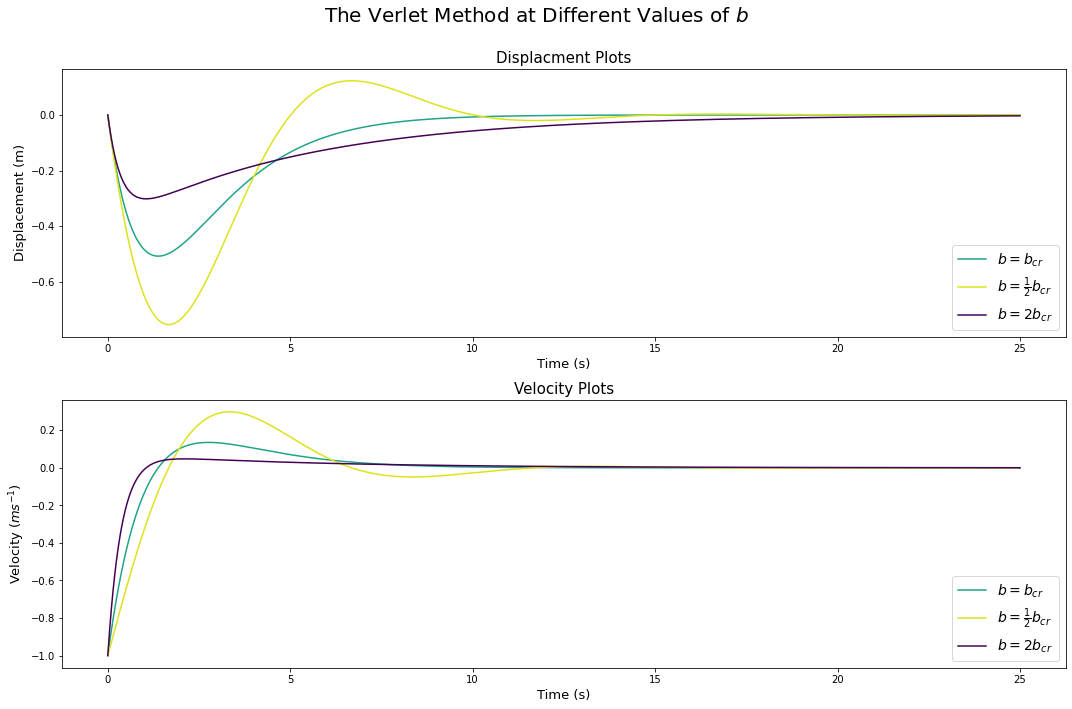

In [136]:
#determining b_cr
B_cr = np.sqrt(4 * K * M) #damping constant, kgs^-1

#setting other physical parameters as well as parameters for the numerical methods
#note: initial conditions used are same as those at beginning of notebook
T = 25 #duration, s
h_best = 0.001 #step size, s
time_values = np.arange(0, T, h_best)

#setting up figure
plt.rcParams["figure.figsize"] = (15, 10)
figure = plt.figure()
figure.suptitle(r'The Verlet Method at Different Values of $b$', fontsize=20)

#setting up the position subplot
b_plot_position = figure.add_subplot(211)
b_plot_position.set_title('\nDisplacment Plots', fontsize=15)
b_plot_position.set_xlabel(r'Time (s)', fontsize=13)
b_plot_position.set_ylabel(r'Displacement (m)', fontsize=13)

#plotting the position plots for different b values
b_cr_position_plot = b_plot_position.plot(time_values, Verlet(M, K, B_cr, h_best)[0], color='#20A387FF', label='$b=b_{cr}$')
half_b_cr_position_plot = b_plot_position.plot(time_values, Verlet(M, K, 0.5 * B_cr, h_best)[0], color='#DCE319FF', 
                                               label=r'$b=\frac{1}{2}b_{cr}$')
twice_b_cr_position_plot = b_plot_position.plot(time_values, Verlet(M, K, 2 * B_cr, h_best)[0], color='#440154FF', 
                                                label='$b=2b_{cr}$')

legend_position = b_plot_position.legend(loc="lower right", fontsize=14)

#setting up the velocity subplot
b_plot_velocity = figure.add_subplot(212)
b_plot_velocity.set_title(r'Velocity Plots', fontsize=15)
b_plot_velocity.set_xlabel(r'Time (s)', fontsize=13)
b_plot_velocity.set_ylabel(r'Velocity ($ms^{-1}$)', fontsize=13)

#plotting the position plots for different b values
b_cr__velocity_plot = b_plot_velocity.plot(time_values, Verlet(M, K, B_cr, h_best)[1], color='#20A387FF', label='$b=b_{cr}$')
half_b_cr_velocity_plot = b_plot_velocity.plot(time_values, Verlet(M, K, 0.5 * B_cr, h_best)[1], color='#DCE319FF', 
                                               label=r'$b=\frac{1}{2}b_{cr}$')
twice_b_cr_velocity_plot = b_plot_velocity.plot(time_values, Verlet(M, K, 2 * B_cr, h_best)[1], color='#440154FF', 
                                                label='$b=2b_{cr}$')

legend_velocity = b_plot_velocity.legend(loc="lower right", fontsize=14)

plt.tight_layout()

These plots show exactly the behavior that we woud expect. The critically damped oscillator $(b=b_{cr})$ returns to equilibrium the quickest and without oscillating, the heavily damped oscillator $(b=2b_{cr})$ doesn't oscillate and slowly returns to equilibrium, and the lightly damped oscillator $(b=\frac{1}{2}b_{cr})$ oscillates as it returns slowly to equilibrium.

## 2. The Driven Damped Harmonic Oscillator

Now that we've established the accuracy of the Verlet method, it's time to use it to solve the driven, damped, harmonic oscillator, for which there isn't necessarily an analytic solution. This means solving the ODE,

$$ma(t) = -bv(t) - kx(t) + F(t)$$ 

where $F$ is some external force. 

### The Verlet Method

This new ODE can be solved by using the Verlet method to give

$$x_{i+1} = Ax_{i} + Bx_{i-1} + \frac{2h^2}{D}F_{i}$$  
$$v_i = \frac{x_{i+1} - x_{i-1}}{2h}$$

where

$$A = 2 \left(\frac{2m-kh^2}{D}\right),\ B = \frac{bh-2m}{D},\ D = 2m + bh$$

Once again, the Verlet method needs to be started with one iteration of another method, e.g. the Improved Euler method. For the case of an external driving force, the Improved Euler Method takes the form  

$$x_{i+1} = x_i +hv_i + \frac{h^2}{2}a_i$$

$$v_{i+1} = v_i + ha_i$$

$$a_i = -\frac{k}{m}x_i - \frac{b}{m}v_i + \frac{F_i}{m}$$

In [137]:
def Verlet_new(T, m, k, b, h, force, x_0, v_0):
    """
    Uses the Verlet method as detailed above to calculate the x and v values at regular time steps
    
    Arguments:
        m (float)
        k (float)
        b (float)
        h (float)
        force (np array of floats)
        x_0 (float)
        v_0 (float)
    Returns:
        verlet_values (np array)
    """
    nsteps = int(T/h)
    
    #constants
    D = 2 * m + b * h
    A = 2 * (2 * m - k * h ** 2) / D
    B = (b * h - 2 * m) / D
    
    x = np.zeros(nsteps)
    v = np.zeros(nsteps)
    x[0] = x_0
    v[0] = v_0
    
    #using the improved euler method to calculate the first iteration
    a = -(k / m) * x[0] - (b / m) * v[0] + (force[0] / m)
    x[1] = x[0] + v[0] * h + ((a * h ** 2) / 2)
    v[1] = v[0] + a * h
   
    #iterating through x and v values as described above
    for i in range(1, nsteps - 1):
        
        x[i + 1] = A * x[i] + B * x[i - 1] + ((2 * h ** 2) / D) * force[i]
        v[i] = (x[i + 1] - x[i - 1]) / (2 * h)
        
    verlet_values = np.array([x, v])
    return verlet_values

### External Force in the Form of a "Push"

One form that the external force can take is a "push", a sudden external force applied after a few oscillations. In the code below, this is implemented as a narrow, tall, half-period of a sine-wave,

$$ F(t) = \begin{cases} 
      A\sin\left(\left(\frac{\pi}{t_{end} -t _{start}}\right) (t - t_{start})\right),\:\: t_{start} \leqslant t \leqslant t_{end} \\
      0,\:\:else\\
   \end{cases}
$$


where A is the ampltiude of the sine wave (i.e. the maximum force exerted during the push), $t_{start}$ and $t_{end}$ are the time at which the push starts and ends. This approach has the advantage of being more physical/realistic than using something more like a step function. Let's plot the effect of varying the amplitude of a 0.1 second push for a lightly damped oscillator with physical parameters as given below (and initial conditions as given at the beginning of the notebook)

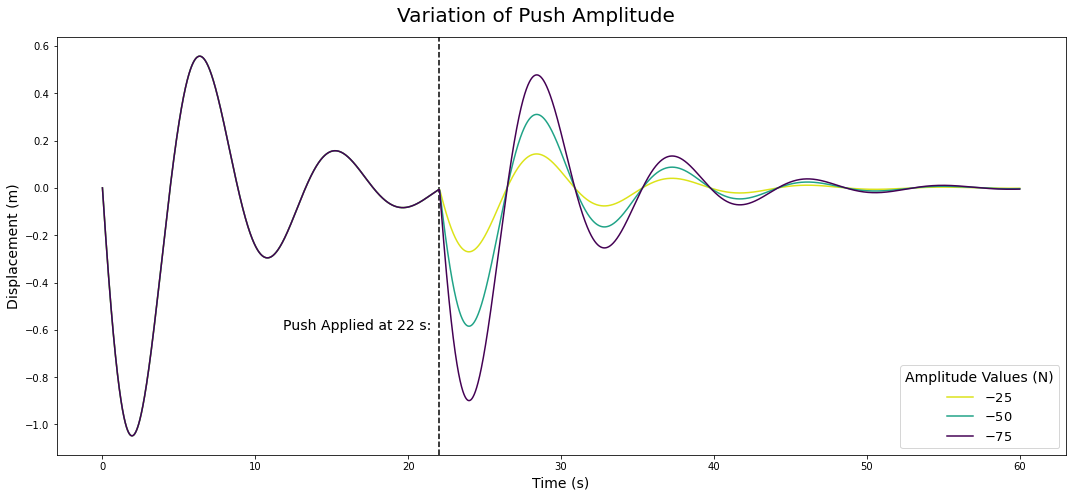

In [138]:
#setting other physical parameters as well as parameters for the numerical methods
DURATION = 60 #duration, s
H = 0.001 #time step, s
T_VALUES = np.arange(0, DURATION, H) #time values considered, s
B = 1.5 #damping constant kgs^1
T_START = 22 #t_start above, s
T_END = 22.1 #t_end above, s

def push(T, h, t_start, t_end, amplitude):
    """
    Produces a "push", a very sharp and tall half period of a sine wave between t_start and t_end with height given by
    amplitude. This can be fed into the Verlet_new function as the "force" argument, the external force applied to the system.
    
    Argument:
        T (float or int)
        h (float)
        t_start (float)
        t_end (float)
        amplitude (float or int)
    Returns:
        force (np array of floats)
    """
    nsteps = int(T / h)
    
    #starting and ending step number
    first_step = int(t_start / h)
    last_step = int(t_end / h)
    
    #number of steps in a push
    n_steps_push = int(last_step - first_step)
    
    #the time values over which the push is applied
    t_push = np.linspace(t_start, t_end, num=n_steps_push)
    
    #force 0 everywhere to start with
    force = np.zeros(nsteps)
    
    #the frequency of the sine wave so that it is 0 at t_end and t_start
    frequency = np.pi / (t_end - t_start)
    
    #for all steps during the push
    for i in range(first_step, last_step):
        
        #force[i] is the force value for the ith step, while t_push[i - first_step] is the the ith time value of the push
        #produces a single 
        force[i] = amplitude * np.abs(np.sin(frequency * (t_push[i - first_step] - t_start)))
        
    return force

#setting up figure
plt.rcParams["figure.figsize"] = (15, 7)
plt.rcParams['legend.title_fontsize'] = '14'
figure = plt.figure()
figure.suptitle(r'Variation of Push Amplitude', fontsize=20)

#setting up subplot
push_amplitude_plot = figure.add_subplot(111)
push_amplitude_plot.set_xlabel(r'Time (s)', fontsize=14)
push_amplitude_plot.set_ylabel(r'Displacement (m)', fontsize=14)

#plotting the time at which the force is applied
push_amplitude_plot.axvline(T_START, 0, 1, linestyle='--', color='black')

#plotting the first amplitude value:
amplitude_1 = -25 #newtons
#calculating the force values
force_values_1 = push(DURATION, H, T_START, T_END, amplitude_1)
#plugging those into the Verlet function to get the solution
Verlet_values_1 = Verlet_new(DURATION, M, K, B, H, force_values_1, x0, v0)[0]
#actually plotting
amplitude_1_plot = push_amplitude_plot.plot(T_VALUES, Verlet_values_1, label='$-25$', color='#DCE319FF')

#plotting the second amplitude value: (same as above)
amplitude_2 = -50 #newtons
force_values_2 = push(DURATION, H, T_START, T_END, amplitude_2)
Verlet_values_2 = Verlet_new(DURATION, M, K, B, H, force_values_2, x0, v0)[0]
amplitude_2_plot = push_amplitude_plot.plot(T_VALUES, Verlet_values_2, label='$-50$', color='#20A387FF')

#plotting the third amplitude value: (same as above)
amplitude_3 = -75 #newtons
force_values_3 = push(DURATION, H, T_START, T_END, amplitude_3)
Verlet_values_3 = Verlet_new(DURATION, M, K, B, H, force_values_3, x0, v0)[0]
amplitude_3_plot = push_amplitude_plot.plot(T_VALUES, Verlet_values_3, label='$-75$', color='#440154FF')

#generating legend and text outlining what the vertical line means
legend_amplitude = push_amplitude_plot.legend(loc="lower right", title='Amplitude Values (N)', fontsize=13)
text = push_amplitude_plot.text(11.8, -0.6, 'Push Applied at {} s:'.format(T_START), fontsize='14')

plt.tight_layout()

Now, for a lightly damped oscillator, let's consider the effect of applying this push in different directions, and at different parts of the oscillator's cycle. Again, this is for the case of a lightly damped oscillator with physical parameters given below (and initial conditions given at the beginning of the notebook). The push lasts for 0.1 seconds and has an amplitude of 60 N; +60 N for the Positive Push plot and -60 N for the Negative Push plot. The black curve represents an unperturbed oscillation, and the colored curves represent oscillators pushed off this path by the force at a time noted in the legend. 

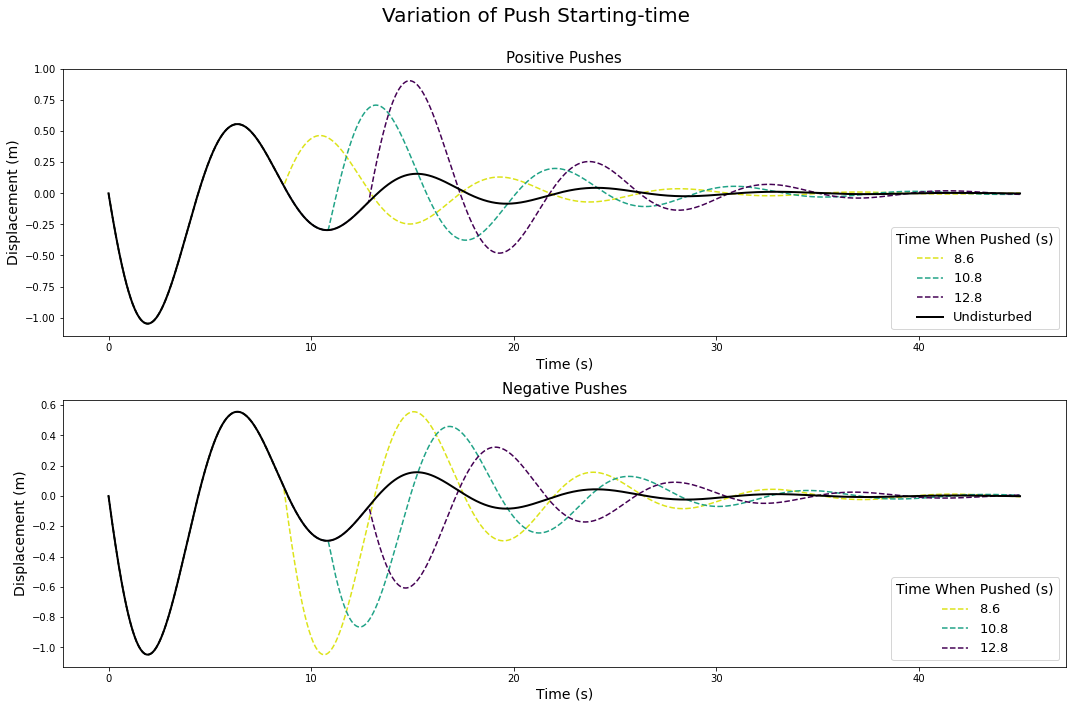

In [139]:
#setting other physical parameters as well as parameters for the numerical methods
DURATION = 45 #duration, s
H = 0.001 #time step, s
T_VALUES = np.linspace(0, DURATION, int(DURATION / H)) #time values considered in the simulation, s
B = 1.5 #damping constant kgs^1
AMPLITUDE = 60 #push amplitude, N

#setting up figure
plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams['legend.title_fontsize'] = '14'
figure = plt.figure()
figure.suptitle(r'Variation of Push Starting-time', fontsize=20)

#setting up t_start variation subplot for POSITIVE pushes:

push_time_plot_pos = figure.add_subplot(211)
push_time_plot_pos.set_title('\nPositive Pushes', fontsize=15)
push_time_plot_pos.set_xlabel(r'Time (s)', fontsize=14)
push_time_plot_pos.set_ylabel(r'Displacement (m)', fontsize=14)

#plotting the first t_start value:

#setting the first t_start value
t_start_1 = 8.6 #t_start above, s
t_end_1 = t_start_1 + 0.1 #t_end above, s

#calculating the force values:
force_values_1 = push(DURATION, H, t_start_1, t_end_1, AMPLITUDE)
#plugging those into the Verlet function to get the solution
Verlet_values_1 = Verlet_new(DURATION, M, K, B, H, force_values_1, x0, v0)[0]
#actually plotting
push_plot_pos_1 = push_time_plot_pos.plot(T_VALUES, Verlet_values_1, '--', label='$8.6$', color='#DCE319FF')

#plotting the second t_start value:

#setting the second t_start value
t_start_2 = 10.8 #t_start above, s
t_end_2 = t_start_2 + 0.1 #t_end above, s

#calculating the force values
force_values_2 = push(DURATION, H, t_start_2, t_end_2, AMPLITUDE)
#plugging those into the Verlet function to get the solution
Verlet_values_2 = Verlet_new(DURATION, M, K, B, H, force_values_2, x0, v0)[0]
#actually plotting
push_plot_pos_2 = push_time_plot_pos.plot(T_VALUES, Verlet_values_2, '--', label='$10.8$', color='#20A387FF')

#plotting the third t_start value:

#setting the third t_start value
t_start_3 = 12.8 #t_start above, s
t_end_3 = t_start_3 + 0.1 #t_end above, s

#calculating the force values
force_values_3 = push(DURATION, H, t_start_3, t_end_3, AMPLITUDE)
#plugging those into the Verlet function to get the solution
Verlet_values_3 = Verlet_new(DURATION, M, K, B, H, force_values_3, x0, v0)[0]
#actually plotting
push_plot_pos_3 = push_time_plot_pos.plot(T_VALUES, Verlet_values_3, '--', label='$12.8$', color='#440154FF')

#plotting a run with no external driving force:
undriven_force = push(DURATION, H, 1, 2, 0)
undriven_values = Verlet_new(DURATION, M, K, B, H, undriven_force, x0, v0)[0]
undriven_plot = push_time_plot_pos.plot(T_VALUES, undriven_values, color='black', linewidth='2', label='Undisturbed')

#generating legend and text noting when the pushes occur
legend_push_time_pos = push_time_plot_pos.legend(loc="lower right", title='Time When Pushed (s)', fontsize=13)

#setting up t_start variation subplot for NEGATIVE pushes:

push_time_plot_neg = figure.add_subplot(212)
push_time_plot_neg.set_title('Negative Pushes', fontsize=15)
push_time_plot_neg.set_xlabel(r'Time (s)', fontsize=14)
push_time_plot_neg.set_ylabel(r'Displacement (m)', fontsize=14)

#plotting the first t_start value:

#calculating the force values:
force_values_1 = push(DURATION, H, t_start_1, t_end_1, -AMPLITUDE)
#plugging those into the Verlet function to get the solution
Verlet_values_1 = Verlet_new(DURATION, M, K, B, H, force_values_1, x0, v0)[0]
#actually plotting
push_plot_neg_1 = push_time_plot_neg.plot(T_VALUES, Verlet_values_1, '--', label='$8.6$', color='#DCE319FF')

#plotting the second t_start value:

#calculating the force values:
force_values_2 = push(DURATION, H, t_start_2, t_end_2, -AMPLITUDE)
#plugging those into the Verlet function to get the solution
Verlet_values_2 = Verlet_new(DURATION, M, K, B, H, force_values_2, x0, v0)[0]
#actually plotting
push_plot_neg_2 = push_time_plot_neg.plot(T_VALUES, Verlet_values_2, '--', label='$10.8$', color='#20A387FF')

#plotting the third t_start value:

#calculating the force values
force_values_3 = push(DURATION, H, t_start_3, t_end_3, -AMPLITUDE)
#plugging those into the Verlet function to get the solution
Verlet_values_3 = Verlet_new(DURATION, M, K, B, H, force_values_3, x0, v0)[0]
#actually plotting
push_plot_neg_3 = push_time_plot_neg.plot(T_VALUES, Verlet_values_3, '--', label='$12.8$', color='#440154FF')

#plotting a run with no external driving force
undriven_force = push(DURATION, H, t_start_3, t_end_3, 0)
undriven_values = Verlet_new(DURATION, M, K, B, H, undriven_force, x0, v0)[0]
undriven_plot = push_time_plot_neg.plot(T_VALUES, undriven_values, color='black', linewidth='2')

#generating legend and text noting when the pushes occur
legend_amplitude = push_time_plot_neg.legend(loc="lower right", title='Time When Pushed (s)', fontsize=13)


plt.tight_layout()

The main takeaway from these runs is that the direction of the push relative to the instantaneous velocity significantly effects the the push's ability to influence the oscillators amplitude. First, let's consider the 8.6 s and 12.8 s runs in the Positive Pushes plot. Comparing the maxima of the first oscillation after the push, we can see that the positive push is able to increase the oscillator's amplitude by a greater amount when the oscillator's instantaneous velocity is also positive. Indeed, even though the 12.8 s run experiences its push later, and so has lost more energy to damping by the time it is pushed, its first maximum is still clearly greater than that of the 8.6 s run. 

This result is mirrored in the Negative Pushes plot where the push has the greatest impact at 8.6 s, when the instantaneous velocity is also negative. In both plots, when the push is applied when the instantaneous velocity is 0, the increase in amplitude is between the increases achieved when the push is in the same and opposite directions as the velocity. Considering the direction of the impulse of the applied force relative to the direction of the oscillators momentum, this is what we would expect to happen;  a positive impulse would lead to a higher final momentum when applied to an oscillator with a more positive initial momentum.

### Sinusoidal External Force:

Now let's consider the case of a sinusoidal external force with a frequency different from the oscillator's undamped natural frequency. We will of course again be using the Verlet method to do so. First we need to implement this sinusoidal force as a function,

$$F(t) = A\sin(\omega t)$$

where A is the amplitude/maximum value of the force, and omega is the frequency of the force. 

In [140]:
def sinusoidal(T, h, omega, amplitude):
    """
    Produces a sinusoidal force of angular frequency omega, and an amplitude given by "amplitude". There is a force value for 
    every time value, as determined by the duration T and the time step h.
    
    Arguments:
        T (float or int)
        h (float or int)
        omega (float or int)
        amplitude (float or int)
    Returns:
        force (np array)
    """
    nsteps = int(T / h)
    
    time_values = np.linspace(0, T, num=nsteps)

    force = amplitude * (np.sin(omega * time_values))
      
    return force

We can investigate this sinusoidal driving force in a number of ways. First, let's apply a sinusoidal force of $\omega=1\,rads^{-1}$ and $A=3\,N$ to our oscillator, but at a number of different initial conditions. Then, keeping initial conditions constant $(x_0=2,\,v_0=0)$, we can vary the angular frequency of the force, keeping $A$ constant. This will be done below for a few values above and a few values below the natural frequency $\omega_0$, given by

$$\omega_0=\sqrt{\frac{k}{m}}$$

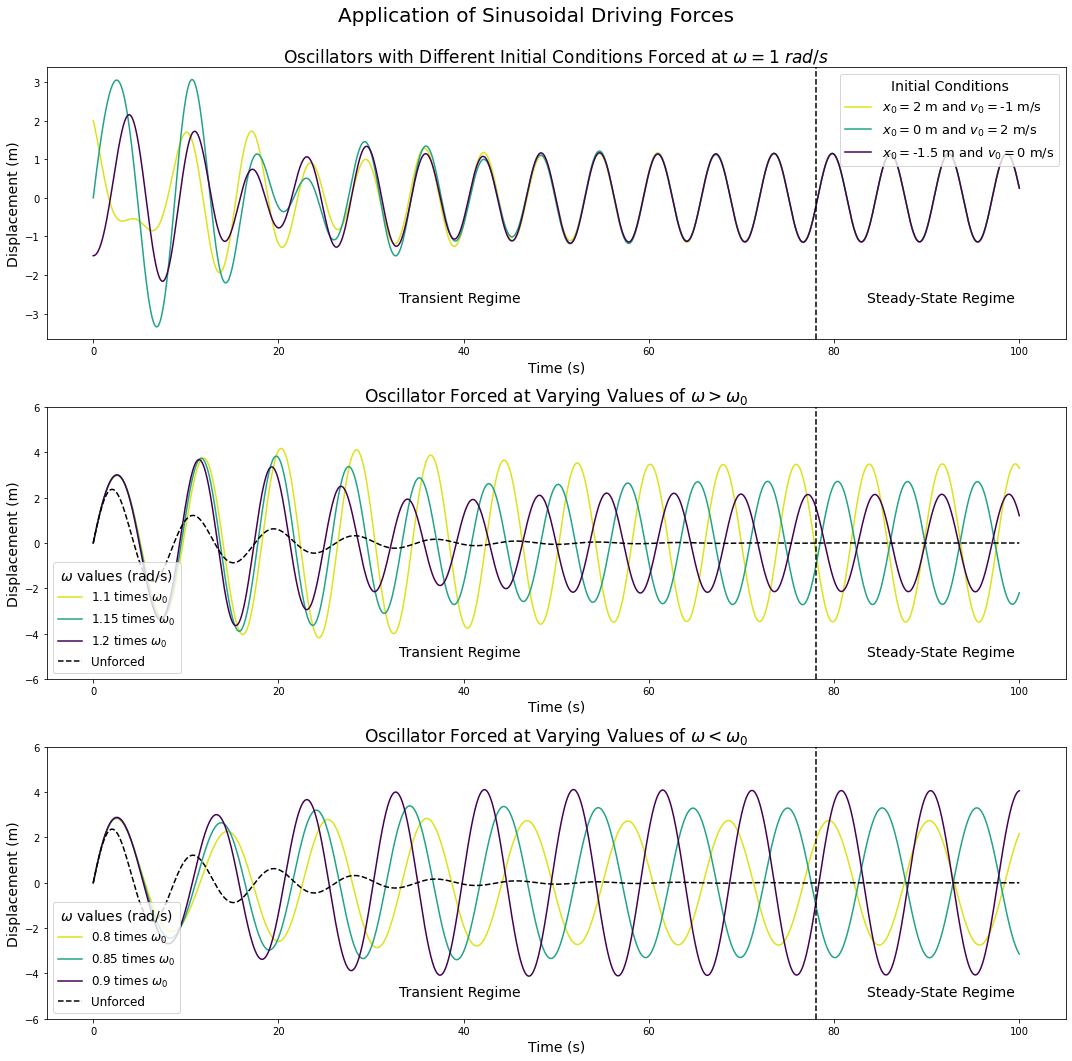

In [141]:
#setting other physical parameters as well as parameters for the numerical methods
DURATION = 100 #duration, s
H = 0.001 #time step, s
T_VALUES = np.linspace(0, DURATION, int(DURATION / H)) #time values considered in the simulation, s
B = 0.8 #damping constant kgs^1
AMPLITUDE = 3 #max force amplitude, N
OMEGA = 1 #angular frequency rads^-1
OMEGA_0 = np.sqrt(K / M)

#setting up figure:

plt.rcParams["figure.figsize"] = (15, 15)
plt.rcParams['legend.title_fontsize'] = '14'
figure = plt.figure()
figure.suptitle(r'Application of Sinusoidal Driving Forces', fontsize=20)

#setting up subplot for oscillators with different IC's forced at same omega:

sine_plot_1 = figure.add_subplot(311)
sine_plot_1.set_title('\nOscillators with Different Initial Conditions Forced at $\omega=${} $rad/s$'.format(OMEGA), 
                      fontsize=17)
sine_plot_1.set_xlabel('Time (s)', fontsize=14)
sine_plot_1.set_ylabel('Displacement (m)', fontsize=14)

#plotting the first set of initial conditions:
x0_1 = 2 #initial position, m
v0_1 = -1 #initial velocity, ms^-1

#calculating the force values:
force_values_1 = sinusoidal(DURATION, H, OMEGA, AMPLITUDE)
#plugging those into the Verlet function to get the solution
Verlet_values_1 = Verlet_new(DURATION, M, K, B, H, force_values_1, x0_1, v0_1)[0]
#plotting
conditions_1_plot = sine_plot_1.plot(T_VALUES, Verlet_values_1, label='$x_0=${} m and $v_0=${} m/s'.format(x0_1, v0_1), 
                                     color='#DCE319FF')

#plotting the second set of initial conditions:
x0_2 = 0 #initial position, m
v0_2 = 2 #initial velocity, ms^-1

#calculating the force values:
force_values_2 = sinusoidal(DURATION, H, OMEGA, AMPLITUDE)
#plugging those into the Verlet function to get the solution
Verlet_values_2 = Verlet_new(DURATION, M, K, B, H, force_values_2, x0_2, v0_2)[0]
#plotting
conditions_2_plot = sine_plot_1.plot(T_VALUES, Verlet_values_2, label='$x_0=${} m and $v_0=${} m/s'.format(x0_2, v0_2), 
                                     color='#20A387FF')

#plotting the third set of initial conditions:
x0_3 = -1.5 #initial position, m
v0_3 = 0 #initial velocity, ms^-1

#calculating the force values:
force_values_3 = sinusoidal(DURATION, H, OMEGA, AMPLITUDE)
#plugging those into the Verlet function to get the solution
Verlet_values_3 = Verlet_new(DURATION, M, K, B, H, force_values_3, x0_3, v0_3)[0]
#plotting
conditions_3_plot = sine_plot_1.plot(T_VALUES, Verlet_values_3, label='$x_0=${} m and $v_0=${} m/s'.format(x0_3, v0_3), 
                                     color='#440154FF')

#plotting a line dividing the transient and steady-state regimes and labeling the two regions
dividing_line_1 = sine_plot_1.axvline(78, 0, 1, linestyle='--', color='black')
transient_text_1 = sine_plot_1.text(33, -2.7, 'Transient Regime', fontsize= 14)
steady_state_text_1 = sine_plot_1.text(83.5, -2.7,'Steady-State Regime', fontsize=14)
#legend
legend_1 = sine_plot_1.legend(loc="upper right", title='Initial Conditions', fontsize=13)

#setting up subplot for same oscillator to be forced at different omega's > omega critical:

#Setting initial conditions:
X0 = 0 #initial position, m
V0 = 2 #initial velocity, ms^-1

sine_plot_2 = figure.add_subplot(312)
sine_plot_2.set_title('Oscillator Forced at Varying Values of $\omega>\omega_0$', fontsize=17)
sine_plot_2.set_xlabel('Time (s)', fontsize=14)
sine_plot_2.set_ylabel('Displacement (m)', fontsize=14)
sine_plot_2.set_ylim([-6, 6])

#plotting the first omega value:
omega_1 = OMEGA_0 * 1.1

#calculating the force values:
omega_force_values_1 = sinusoidal(DURATION, H, omega_1, AMPLITUDE)
#plugging those into the Verlet function to get the solution
omega_Verlet_values_1 = Verlet_new(DURATION, M, K, B, H, omega_force_values_1, X0, V0)[0]
#plotting
omega_1_plot = sine_plot_2.plot(T_VALUES, omega_Verlet_values_1, label='1.1 times $\omega_0$', color='#DCE319FF')

#plotting the second omega value:
omega_2 = OMEGA_0 * 1.15

#calculating the force values:
omega_force_values_2 = sinusoidal(DURATION, H, omega_2, AMPLITUDE)
#plugging those into the Verlet function to get the solution
omega_Verlet_values_2 = Verlet_new(DURATION, M, K, B, H, omega_force_values_2, X0, V0)[0]
#plotting
omega_2_plot = sine_plot_2.plot(T_VALUES, omega_Verlet_values_2, label='1.15 times $\omega_0$', color='#20A387FF')

#plotting the third omega value:
omega_3 = OMEGA_0 * 1.2

#calculating the force values:
omega_force_values_3 = sinusoidal(DURATION, H, omega_3, AMPLITUDE)
#plugging those into the Verlet function to get the solution
omega_Verlet_values_3 = Verlet_new(DURATION, M, K, B, H, omega_force_values_3, X0, V0)[0]
#plotting
omega_3_plot = sine_plot_2.plot(T_VALUES, omega_Verlet_values_3, label='1.2 times $\omega_0$', color='#440154FF')

#plotting the unforced oscillator:
omega_unforced_force_values = sinusoidal(DURATION, H, omega_3, 0)
#plugging those into the Verlet function to get the solution
omega_unforced_Verlet_values = Verlet_new(DURATION, M, K, B, H, omega_unforced_force_values, X0, V0)[0]
#plotting
omega_unforced_plot = sine_plot_2.plot(T_VALUES, omega_unforced_Verlet_values, '--', label='Unforced', color='black')

#plotting a line dividing the transient and steady-state regimes and labeling the two regions
dividing_line_2 = sine_plot_2.axvline(78, 0, 1, linestyle='--', color='black')
transient_text_2 = sine_plot_2.text(33, -5, 'Transient Regime', fontsize= 14)
steady_state_text_2 = sine_plot_2.text(83.5, -5,'Steady-State Regime', fontsize=14)
#legend
legend_2 = sine_plot_2.legend(loc="lower left", title='$\omega$ values (rad/s)', fontsize=12)

#setting up subplot for same oscillator to be forced at different omega's < omega critical:

sine_plot_3 = figure.add_subplot(313)
sine_plot_3.set_title('Oscillator Forced at Varying Values of $\omega<\omega_0$', fontsize=17)
sine_plot_3.set_xlabel('Time (s)', fontsize=14)
sine_plot_3.set_ylabel('Displacement (m)', fontsize=14)
sine_plot_3.set_ylim([-6, 6])

#plotting the fourth omega value:
omega_4 = OMEGA_0 * 0.8

#calculating the force values:
omega_force_values_4 = sinusoidal(DURATION, H, omega_4, AMPLITUDE)
#plugging those into the Verlet function to get the solution
omega_Verlet_values_4 = Verlet_new(DURATION, M, K, B, H, omega_force_values_4, X0, V0)[0]
#plotting
omega_4_plot = sine_plot_3.plot(T_VALUES, omega_Verlet_values_4, label='0.8 times $\omega_0$', color='#DCE319FF')

#plotting the fifth omega value:
omega_5 = OMEGA_0 * 0.85

#calculating the force values:
omega_force_values_5 = sinusoidal(DURATION, H, omega_5, AMPLITUDE)
#plugging those into the Verlet function to get the solution
omega_Verlet_values_5 = Verlet_new(DURATION, M, K, B, H, omega_force_values_5, X0, V0)[0]
#plotting
omega_5_plot = sine_plot_3.plot(T_VALUES, omega_Verlet_values_5, label='0.85 times $\omega_0$', color='#20A387FF')

#plotting the sixth omega value:
omega_6 = OMEGA_0 * 0.9

#calculating the force values:
omega_force_values_6 = sinusoidal(DURATION, H, omega_6, AMPLITUDE)
#plugging those into the Verlet function to get the solution
omega_Verlet_values_6 = Verlet_new(DURATION, M, K, B, H, omega_force_values_6, X0, V0)[0]
#plotting
omega_6_plot = sine_plot_3.plot(T_VALUES, omega_Verlet_values_6, label='0.9 times $\omega_0$', color='#440154FF')

#plotting the unforced oscillator:
omega_unforced_force_values = sinusoidal(DURATION, H, omega_3, 0)
#plugging those into the Verlet function to get the solution
omega_unforced_Verlet_values = Verlet_new(DURATION, M, K, B, H, omega_unforced_force_values, X0, V0)[0]
#plotting
omega_unforced_plot = sine_plot_3.plot(T_VALUES, omega_unforced_Verlet_values, '--', label='Unforced', color='black')

#plotting a line dividing the transient and steady-state regimes and labeling the two regions
dividing_line_2 = sine_plot_3.axvline(78, 0, 1, linestyle='--', color='black')
transient_text_2 = sine_plot_3.text(33, -5, 'Transient Regime', fontsize= 14)
steady_state_text_2 = sine_plot_3.text(83.5, -5,'Steady-State Regime', fontsize=14)
#legend
legend_2 = sine_plot_3.legend(loc="lower left", title='$\omega$ values (rad/s)', fontsize=12)

plt.tight_layout()

A lot of insight can be gained from these simulations. First, considering the top plot, we can see that when a sinusoidal driving force is applied, the transient regime is highly dependent on the initial conditions, but the steady-state regime depends only on $\omega$. In fact, the placement of the line denoting the two regimes was determined by the point at which all the initial condition curves in the top plot were visibly indistinguishable. It should be noted however, that there is no definite point at which the change occurs because it depends on the exponential decay of the solution due to damping. Indeed, looking at the bottom plot, this line coincides with where the unforced solution falls to ~0. This is because the "end" of transience coincides with the decay of the unforced oscillator to ~0, meaning any resistance to the driving force has effectively vanished and the oscillator oscillates at $\omega$. 

In the middle and bottom plots, multiple values of $\omega$, in terms of $\omega_0$, are plotted. The main take-away here is that the closer that $\omega$ gets to $\omega_0$, the greater the amplitude in the steady state-regime. This is consistent with what we would expect, given a qualitative understanding of resonance. 

## 3. Resonance

Having seen resonance qualitatively, let's now investigate resonance more quantitatively. Resonance is a phenomenon in which the amplitude of a DDHO increases the closer the driving frequency $\omega$ is to the natural frequency $\omega_0$. The exact relationship between $\omega$ and this amplitude $A$ can be found analytically as

$$A(\omega) = \frac{\frac{F_0}{m}}{\sqrt{(\omega_0^2 - \omega^2)^2 + \omega^2\gamma^2}}$$

where $F_0$ is the amplitude of the driving force, and $\gamma=\frac{b}{m}$. Seeing as we'll be plotting the amplitudes of damped, driven oscillators in the steady state regime, we need to be able to determine when the steady state regime "begins". Recall that the beginning of the steady state regime coincides with the undriven solution effectively vanishing. We can determine at which point this occurs by determining the time at which the exponential factor in the analytic DHO solution,

$$e^{-\gamma t / 2}$$

falls below a given accuracy. This is implemented in the code below for the following parameters.

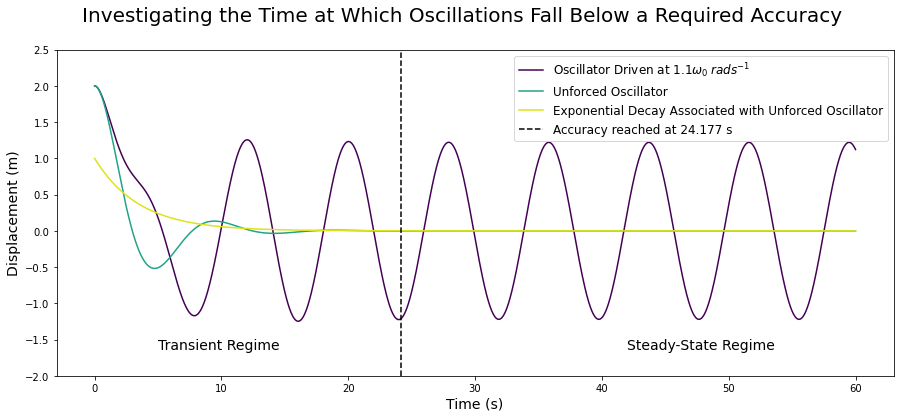

In [142]:
#setting other physical parameters as well as parameters for the numerical methods:
DURATION = 60 #duration, s
H = 0.001 #time step, s
T_VALUES = np.linspace(0, DURATION, int(DURATION / H)) #time values considered in the simulation, s
B_RESONANCE = 3 #damping constant kgs^1
AMPLITUDE = 3 #max force amplitude, N
X0_RESONANCE = 2 #initial position, m
V0_RESONANCE = 0 #initial velocity, ms^-1
ACCURACY = 0.001 #the accuracy/value to which we want the exponential to decay to
OMEGA_0 = np.sqrt(K / M) #natural frequency, rads^-1
GAMMA = B_RESONANCE / M #decay constant of the exponential

def steady_state_check(values, h):
    """
    Finds the first value in an array of values at regular time steps, "values", below a given accuracy and returns the time 
    at which this happens
    
    Arguments:
        values (np array)
        h (float)
    Returns:
        reached (boolean)
        time (float)
    """
    reached = False
    
    for i, value in enumerate(values):
    
        if np.abs(value) < ACCURACY:
            
            time = i * h
            reached = True
            
            return reached, time
    
    print("Accuracy Could Not Be Reached")
    return reached, 0

#setting up figure:

plt.rcParams["figure.figsize"] = (15, 6)
plt.rcParams['legend.title_fontsize'] = '14'
figure = plt.figure()
figure.suptitle(r'Investigating the Time at Which Oscillations Fall Below a Required Accuracy', fontsize=20)

#setting up subplot
accuracy_plot = figure.add_subplot(111)
accuracy_plot.set_xlabel('Time (s)', fontsize=14)
accuracy_plot.set_ylabel('Displacement (m)', fontsize=14)
accuracy_plot.set_ylim([-2, 2.5])

#plotting a plot of the oscillator being driven at some frequency, 1.1 * omega_0:
resonance_force_values = sinusoidal(DURATION, H, 1.1 * OMEGA_0, AMPLITUDE)
resonance_Verlet_values = Verlet_new(DURATION, M, K, B_RESONANCE, H, resonance_force_values, X0_RESONANCE, V0_RESONANCE)[0]
driven_plot = accuracy_plot.plot(T_VALUES, resonance_Verlet_values, label='Oscillator Driven at 1.1$\omega_0\: rads^{-1}$',
                                 color='#440154FF')

#plotting the unforced oscillator:
unforced_force_values = sinusoidal(DURATION, H, 1.1 * OMEGA_0, 0)
unforced_Verlet_values = Verlet_new(DURATION, M, K, B_RESONANCE, H, unforced_force_values, X0_RESONANCE, V0_RESONANCE)[0]
unforced_plot = accuracy_plot.plot(T_VALUES, unforced_Verlet_values, label='Unforced Oscillator', color='#20A387FF')

#plotting the analytic solution of the envelope exponential:
analytic_decay = np.exp((-GAMMA / 2) * T_VALUES)
analytic_decay_plot = accuracy_plot.plot(T_VALUES, analytic_decay, 
                                         label='Exponential Decay Associated with Unforced Oscillator', color='#DCE319FF')

#determining the time at which the exponential falls below the accuracy value
steady_state_values = steady_state_check(analytic_decay, H)
#plotting this value if it is reached in the time range given
if steady_state_values[0] == True:
    dividing_line = accuracy_plot.axvline(steady_state_values[1], 0, 1, linestyle='--', color='black', 
                                          label='Accuracy reached at {:.3f} s'.format(steady_state_values[1]))
    
#legend
accuracy_legend = accuracy_plot.legend(fontsize=12)
#text labelling the two regimes
transient_text_2 = accuracy_plot.text(5, -1.63, 'Transient Regime', fontsize= 14)
steady_state_text_2 = accuracy_plot.text(42, -1.63,'Steady-State Regime', fontsize=14)

Keep in mind, this time is independent of $\omega$ and so be can used for every $\omega$ that we consider (given that the other physical parameters are held constant). Now, using these parameters and running simulations for a number of $\omega$ values, we can plot a numerical solution, as well as an analytical solution, for $A=A(\omega)$. This is done by (for each value of $\omega$) running a Verlet method simulation until the steady-state regime is reached, and then calculating the amplitude, the maximum value of the displacement over the course of a period $T$. Where $T$ is of course given by

$$T=\frac{2\pi}{\omega}$$

This computation involves dozens of simulations and so will take a relatively longer time to run. Therefore, the code below was written in such a way as to minimize the number of calculations required. Firstly, the simulation runs only until the steady state regime is reached, and then for one period more. This is the minimum amount of time required to carry out the procedure to calculate $A$ as outlined; the Verlet method simulation only needs to run for the minimum amount of time, and the search for the maximum value is confined to only one period, the minimum range guaranteed to give the correct result.

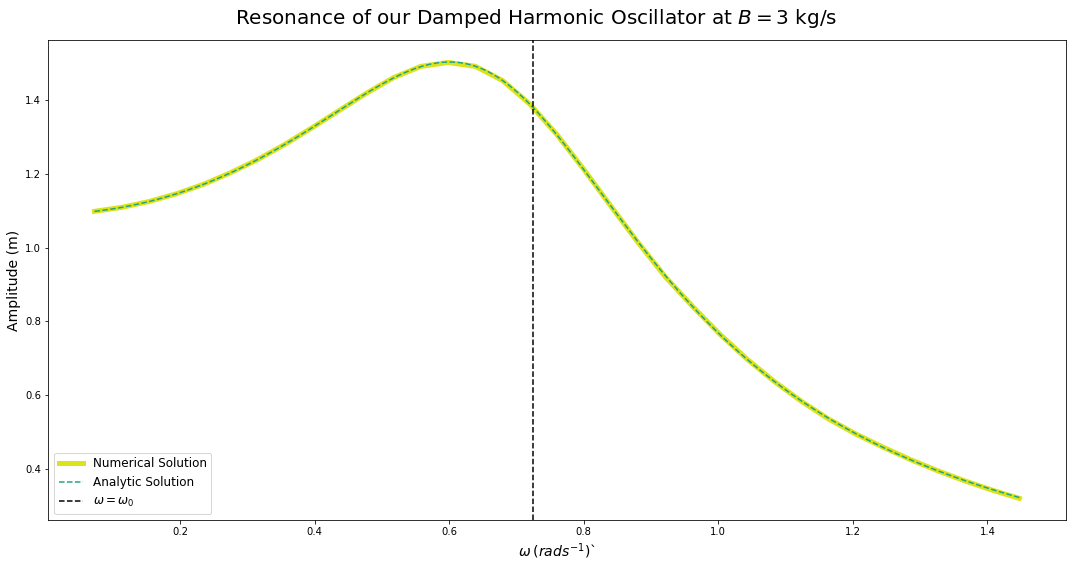

In [143]:
#setting other physical parameters as well as parameters for the numerical methods:
H = 0.0001 #time step, s
F_0 = 3 #ampltidue of the sinusoidal driving force, N
OMEGA_0 = np.sqrt(K / M) #natural frequency, rads^-1
OMEGA_MIN = 0.1 * OMEGA_0 #minimum omega value plotted by the numerical solution, rads^-1
OMEGA_MAX = 2 * OMEGA_0 #maximum omega value plotted by the numerical solution, rads^-1
N_OMEGA_VALUES = 35 #number of omega values plotted by the numerical solution

def steady_state_amplitude(omega, h, steady_state_beginning, f_0, m, k, b, x0_resonance, v0_resonance):
    """
    For each value of omega, runs the Verlet method until the steady-state regime is entered, and then runs for one more
    period 2pi/omega. In this first period of the steady-state regime, the maximum displacement i.e. the amplitude, is 
    calculated. This collection of amplitudes is then outputted.
    
    Arguments:
        omega (np array)
        h (float or int)
        steady_state_beginning (float)
        f_0 (float or int)
        m (float)
        k (float)
        b (float or int)
    Returns:
        amplitude_values (np array)
    """
    #creating the array for the amplitude values
    amplitude_values = np.empty(0)
    
    #the minimum time considered in finding the maximum is when we determined the steady state regime to have begun
    min_time = steady_state_beginning 

    for i, omega_value in enumerate(omega):
        
        #the maximum time considered in finding the maximum is the minimum + the corresponding period
        max_time = min_time + 2 * np.pi / omega_value
        
        #time steps corresponding to the beginning and end of the times considered
        min_step = int(min_time / h)
        max_step = int(max_time / h)
        
        #time values considered in the simulation (0 to max_time s)
        t_values = np.linspace(0, max_time, num=int(max_time / h)) 
        #force values considered in this simulation
        force_values = sinusoidal(max_time, h, omega_value, f_0)
        #corresponding verlet values
        Verlet_values = Verlet_new(max_time, m, k, b, h, force_values, x0_resonance, v0_resonance)[0]
        
        #verlet values within the first period of the steady state regime
        steady_state_verlet_values = Verlet_values[min_step:max_step]
        #time values within the first period of the steady state regime: done like this to avoid rounding errors causing 
        #steady_state_t_values and steady_state_verlet_values to have different lengths
        steady_state_t_values = h * np.linspace(min_step, max_step, num=(max_step - min_step))

        #the maximum over the course this first period; the amplitude
        amplitude = np.amax(steady_state_verlet_values)
        
        #adding amplitude value to the results array
        amplitude_values = np.append(amplitude_values, amplitude)
        
    return amplitude_values

def analytic_resonance(f_0, m, k, b, omega_0, omega_min, omega_max):
    """
    Analytic equation for resonance as function of omega as written above. Also generates the omega values to be used
    using the minimum and maximum omega values desired.
    
    Arguments: 
        f_0 (float or int)
        m (float)
        k (float)
        b(float or int)
        omega_0 (float)
        omega_min(float or int)
        omega_max (float or int)
    Returns:
        omega (np array)
        ana_amplitude (np array)
    """
    
    omega = np.linspace(omega_min, omega_max, num=200)
    
    A = f_0 / m
    B_1 = (omega_0 ** 2 - omega ** 2) ** 2
    C = (omega * b / m) ** 2
    
    ana_amplitude = A / np.sqrt(B_1 + C)

    return omega, ana_amplitude

#setting up figure:
plt.rcParams["figure.figsize"] = (15, 8)
plt.rcParams['legend.title_fontsize'] = '14'
figure = plt.figure()
figure.suptitle(r'Resonance of our Damped Harmonic Oscillator at $B={}$ kg/s'.format(B_RESONANCE), fontsize=20)

#setting up subplot:
resonance_plot = figure.add_subplot(111)
resonance_plot.set_xlabel('$\omega\: (rads^{-1}$)`', fontsize=14)
resonance_plot.set_ylabel('Amplitude (m)', fontsize=14)

#plotting the numerical solution:
omega_values = np.linspace(OMEGA_MIN, OMEGA_MAX, num=N_OMEGA_VALUES)
amplitude_values = steady_state_amplitude(omega_values, H, steady_state_values[1], F_0, M, K, B_RESONANCE, X0_RESONANCE, 
                                          V0_RESONANCE)
resonance_curve = resonance_plot.plot(omega_values, amplitude_values, label='Numerical Solution', color='#DCE319FF',
                                      linewidth=5)

#plotting the analytic solution:
ana_omega_values, ana_amplitude_values = analytic_resonance(F_0, M, K, B_RESONANCE, OMEGA_0, OMEGA_MIN, OMEGA_MAX)
ana_resonance_curve = resonance_plot.plot(ana_omega_values, ana_amplitude_values, '--', label='Analytic Solution', 
                                      color='#20A387FF')

#plotting line at omega = omega_0
omega_0_line = resonance_plot.axvline(OMEGA_0, 0, 1, linestyle='--', color='black', label='$\omega=\omega_0$')
#legend
resonance_legend = resonance_plot.legend(loc='lower left', fontsize=12)

plt.tight_layout()

As can be seen, our solution matches the analytic solution very well. It should be noted that the numerical solution curve was made wider for the sake of visibility; this has no physical significance. 

## 4. Other Periodic Driving Functions

Now that we've investigated a sinusoidal driving force, let's investigate some other periodic driving forces, namely sawtooth and square waves. To aid in visualizing the form of these driving forces, they are plotted according to the parameters below. All driving forces have the same frequency and amplitude, and are implemented in such a way as to be somewhat similar to the form of the sinusoidal force. For example, the sawtooth wave is implemented so that $F=0$ at $t=0$.

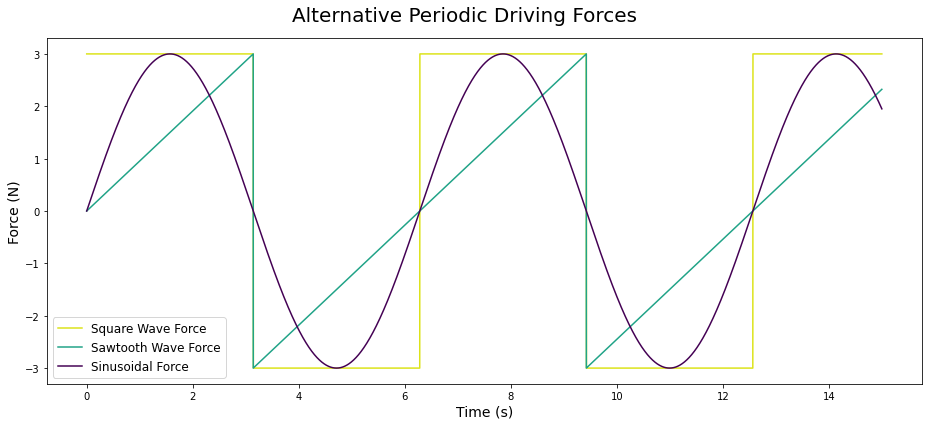

In [144]:
#setting other physical parameters as well as parameters for the numerical methods
DURATION = 15 #duration, s
H = 0.001 #time step, s
T_VALUES = np.linspace(0, DURATION, int(DURATION / H)) #time values considered in the simulation, s
B = 0.8 #damping constant kgs^1
AMPLITUDE = 3 #max force amplitude, N
OMEGA = 1 #angular frequency rads^-1

def squarewave(T, h, omega, amplitude):
    """
    Produces a square-wave force of angular frequency omega, and an amplitude given by "amplitude". There is a force value for 
    every time value, as determined by the duration T and the time step h.
    
    Arguments:
        T (float or int)
        h (float or int)
        omega (float or int)
        amplitude (float or int)
    Returns:
        force (np array)
    """
    nsteps = int(T / h)
    
    time_values = np.linspace(0, T, num=nsteps)
    force = amplitude * (signal.square(omega * time_values))
      
    return force

def sawtooth(T, h, omega, amplitude):
    """
    Produces a sawtooth-wave force of angular frequency omega, and an amplitude given by "amplitude". There is a force value for
    every time value, as determined by the duration T and the time step h.
    
    Arguments:
        T (float or int)
        h (float or int)
        omega (float or int)
        amplitude (float or int)
    Returns:
        force (np array)
    """
    nsteps = int(T / h)
    
    time_values = np.linspace(0, T, num=nsteps)
    force = amplitude * (signal.sawtooth(omega * (time_values + np.pi)))
      
    return force

#setting up figure:
plt.rcParams["figure.figsize"] = (13, 6)
plt.rcParams['legend.title_fontsize'] = '14'
figure = plt.figure()
figure.suptitle(r'Alternative Periodic Driving Forces', fontsize=20)

#setting up subplot:
driving_forces_plot = figure.add_subplot(111)
driving_forces_plot.set_xlabel('Time (s)', fontsize=14)
driving_forces_plot.set_ylabel('Force (N)', fontsize=14)

#plotting the driving forces:
driving_forces_plot.plot(T_VALUES, squarewave(DURATION, H, OMEGA, AMPLITUDE), label='Square Wave Force', color='#DCE319FF')
driving_forces_plot.plot(T_VALUES, sawtooth(DURATION, H, OMEGA, AMPLITUDE), label='Sawtooth Wave Force', color='#20A387FF')
driving_forces_plot.plot(T_VALUES, sinusoidal(DURATION, H, OMEGA, AMPLITUDE), label='Sinusoidal Force', color='#440154FF')

driving_forces_plot_legend = driving_forces_plot.legend(loc='lower left', fontsize=12)

plt.tight_layout()

Now let's use these forces to drive a damped harmonic oscillator for a few $\omega$ values, according to parameters given below. Note again that all forces have the same amplitude.

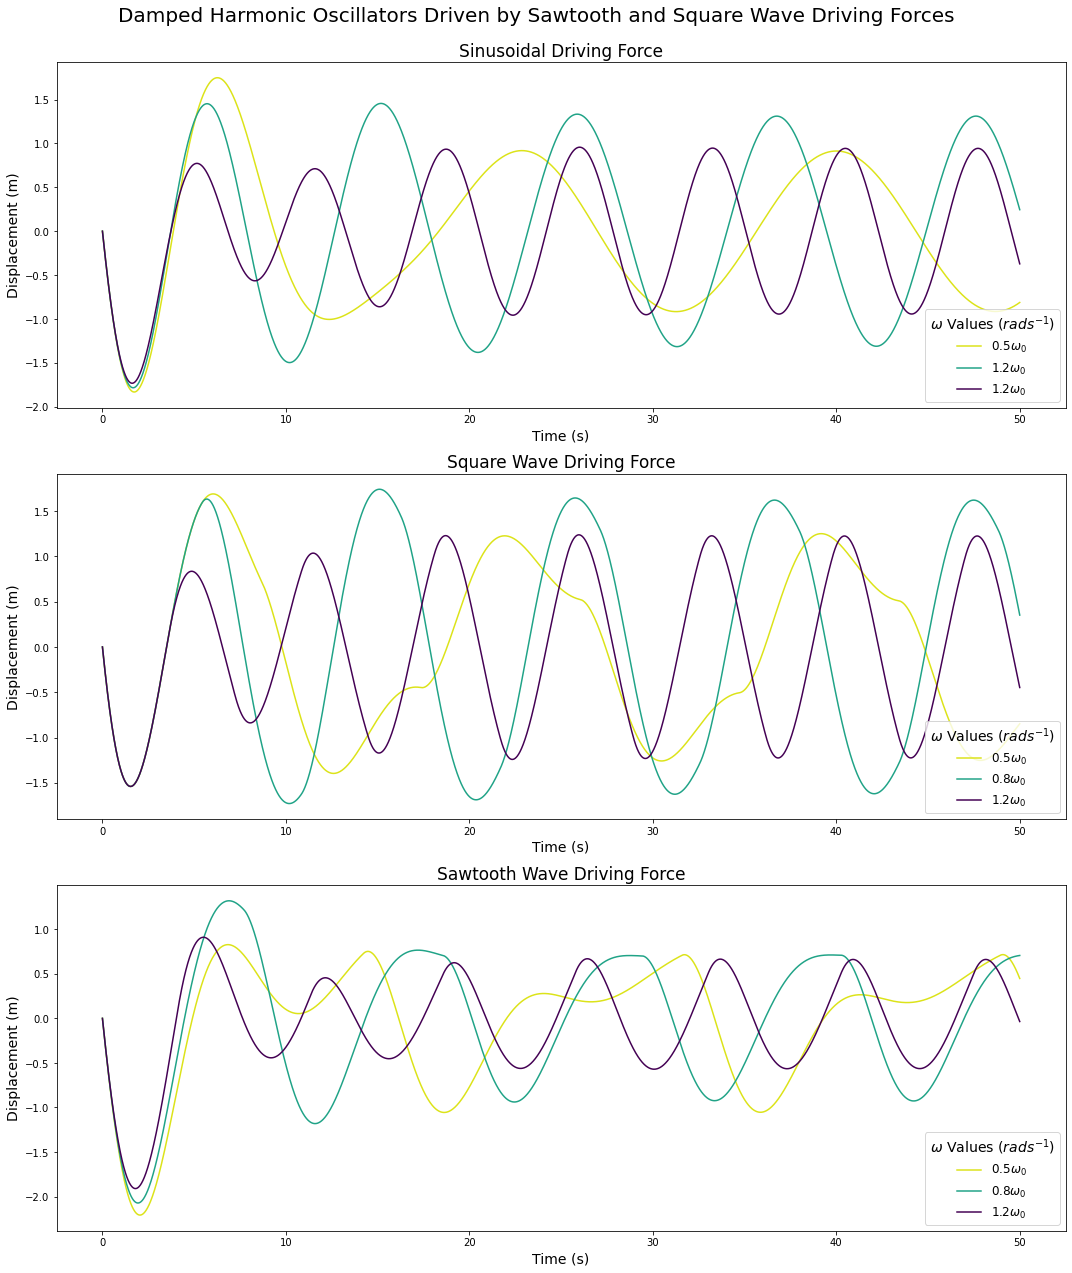

In [145]:
#setting other physical parameters as well as parameters for the numerical methods
DURATION = 50 #duration, s
H = 0.001 #time step, s
T_VALUES = np.linspace(0, DURATION, int(DURATION / H)) #time values considered in the simulation, s
B = 2 #damping constant kgs^1
AMPLITUDE = 2 #max force amplitude, N
OMEGA_0 = np.sqrt(K / M) #natural frequency, rads^-1
X0_DRIVING = 0
V0_DRIVING = -2

FACTOR_1 = 0.5
OMEGA_1 = OMEGA_0 * FACTOR_1
FACTOR_2 = 0.8
OMEGA_2 = OMEGA_0 * FACTOR_2
FACTOR_3 = 1.2
OMEGA_3 = OMEGA_0 * FACTOR_3

#setting up figure:
plt.rcParams["figure.figsize"] = (15, 18)
plt.rcParams['legend.title_fontsize'] = '14'
figure = plt.figure()
figure.suptitle(r'Damped Harmonic Oscillators Driven by Sawtooth and Square Wave Driving Forces', fontsize=20)

#setting up sinusoidal force subplot:
sinusoidal_force_plot = figure.add_subplot(311)
sinusoidal_force_plot.set_title('\nSinusoidal Driving Force', fontsize=17)
sinusoidal_force_plot.set_xlabel('Time (s)', fontsize=14)
sinusoidal_force_plot.set_ylabel('Displacement (m)', fontsize=14)

#plot of sinusoidal force at omega_1
sinusoidal_force_values_1 = sinusoidal(DURATION, H, OMEGA_1, AMPLITUDE)
sinusoidal_Verlet_values_1 = Verlet_new(DURATION, M, K, B, H, sinusoidal_force_values_1, X0_DRIVING, V0_DRIVING)[0]
sinudoidal_driven_plot_1 = sinusoidal_force_plot.plot(T_VALUES, sinusoidal_Verlet_values_1, 
                                                      label='{}$\omega_0$'.format(FACTOR_1),
                                                      color='#DCE319FF')

#plot of sinusoidal force at omega_2
sinusoidal_force_values_2 = sinusoidal(DURATION, H, OMEGA_2, AMPLITUDE)
sinusoidal_Verlet_values_2 = Verlet_new(DURATION, M, K, B, H, sinusoidal_force_values_2, X0_DRIVING, V0_DRIVING)[0]
sinudoidal_driven_plot_2 = sinusoidal_force_plot.plot(T_VALUES, sinusoidal_Verlet_values_2, 
                                                      label='{}$\omega_0$'.format(FACTOR_2),
                                                      color='#20A387FF')

#plot of sinusoidal force at omega_3
sinusoidal_force_values_3 = sinusoidal(DURATION, H, OMEGA_3, AMPLITUDE)
sinusoidal_Verlet_values_3 = Verlet_new(DURATION, M, K, B, H, sinusoidal_force_values_3, X0_DRIVING, V0_DRIVING)[0]
sinudoidal_driven_plot_3 = sinusoidal_force_plot.plot(T_VALUES, sinusoidal_Verlet_values_3, 
                                                      label='{}$\omega_0$'.format(FACTOR_3),
                                                      color='#440154FF')
#legend
sinusoidal_forces_plot_legend = sinusoidal_force_plot.legend(title='$\omega$ Values ($rads^{-1}$)', fontsize=12)

#setting up squarewave force subplot:
square_force_plot = figure.add_subplot(312)
square_force_plot.set_title('Square Wave Driving Force', fontsize=17)
square_force_plot.set_xlabel('Time (s)', fontsize=14)
square_force_plot.set_ylabel('Displacement (m)', fontsize=14)

#plot of square force at omega_1
square_force_values_1 = squarewave(DURATION, H, OMEGA_1, AMPLITUDE)
square_Verlet_values_1 = Verlet_new(DURATION, M, K, B, H, square_force_values_1, X0_DRIVING, V0_DRIVING)[0]
square_driven_plot_1 = square_force_plot.plot(T_VALUES, square_Verlet_values_1, 
                                                  label='{}$\omega_0$'.format(FACTOR_1),
                                                  color='#DCE319FF')

#plot of square force at omega_2
square_force_values_2 = squarewave(DURATION, H, OMEGA_2, AMPLITUDE)
square_Verlet_values_2 = Verlet_new(DURATION, M, K, B, H, square_force_values_2, X0_DRIVING, V0_DRIVING)[0]
square_driven_plot_2 = square_force_plot.plot(T_VALUES, square_Verlet_values_2, 
                                                  label='{}$\omega_0$'.format(FACTOR_2),
                                                  color='#20A387FF')

#plot of square force at omega_3
square_force_values_3 = squarewave(DURATION, H, OMEGA_3, AMPLITUDE)
square_Verlet_values_3 = Verlet_new(DURATION, M, K, B, H, square_force_values_3, X0_DRIVING, V0_DRIVING)[0]
square_driven_plot_3 = square_force_plot.plot(T_VALUES, square_Verlet_values_3, 
                                                  label='{}$\omega_0$'.format(FACTOR_3),
                                                  color='#440154FF')

#legend
square_forces_plot_legend = square_force_plot.legend(loc='lower right', title='$\omega$ Values ($rads^{-1}$)', fontsize=12)

#setting up sawtooth force subplot:
saw_force_plot = figure.add_subplot(313)
saw_force_plot.set_title('Sawtooth Wave Driving Force', fontsize=17)
saw_force_plot.set_xlabel('Time (s)', fontsize=14)
saw_force_plot.set_ylabel('Displacement (m)', fontsize=14)

#plot of saw force at omega_1
saw_force_values_1 = sawtooth(DURATION, H, OMEGA_1, AMPLITUDE)
saw_Verlet_values_1 = Verlet_new(DURATION, M, K, B, H, saw_force_values_1, X0_DRIVING, V0_DRIVING)[0]
saw_driven_plot_1 = saw_force_plot.plot(T_VALUES, saw_Verlet_values_1, 
                                        label='{}$\omega_0$'.format(FACTOR_1),
                                        color='#DCE319FF')

#plot of saw force at omega_2
saw_force_values_2 = sawtooth(DURATION, H, OMEGA_2, AMPLITUDE)
saw_Verlet_values_2 = Verlet_new(DURATION, M, K, B, H, saw_force_values_2, X0_DRIVING, V0_DRIVING)[0]
saw_driven_plot_2 = saw_force_plot.plot(T_VALUES, saw_Verlet_values_2, 
                                        label='{}$\omega_0$'.format(FACTOR_2),
                                        color='#20A387FF')

#plot of saw force at omega_3
saw_force_values_3 = sawtooth(DURATION, H, OMEGA_3, AMPLITUDE)
saw_Verlet_values_3 = Verlet_new(DURATION, M, K, B, H, saw_force_values_3, X0_DRIVING, V0_DRIVING)[0]
saw_driven_plot_3 = saw_force_plot.plot(T_VALUES, saw_Verlet_values_3, 
                                        label='{}$\omega_0$'.format(FACTOR_3),
                                        color='#440154FF')

#legend
saw_forces_plot_legend = saw_force_plot.legend(title='$\omega$ Values ($rads^{-1}$)', fontsize=12)

plt.tight_layout()

There are a number of interesting features to note from these plots. Firstly, the square wave seems to have the largest influence on the steady state amplitude of the oscillator, while the sawtooth wave seems to have the smallest. This agrees with what we might expect, having looked at the plots of the forces earlier; the sawtooth wave spends a considerably smaller fraction of a period at maximum, or near-maximum, force as compared to the sine and square waves. Another observation is that the steady state displacement-time curves produced by the sawtooth and square waves, despite being periodic, don't appear to be sine waves or sawtooth/square waves. Indeed, they appear to be some superposition of sine waves. Interestingly, the curves appear to become more "sine-like" the larger the associated $\omega$.

Additionally, all the driving forces lead to the oscillator experiencing a transient and steady state regime...and these regimes all line up. However, given the physical reasoning behind the transition to the steady state regime described earlier, this shouldn't come as a surprise. In all three cases, the decay of the unforced solution occurs at the same rate, and so the driving forces begin to dominate at the same time.

Perhaps most intriguingly, from this cursory look it appears that the square wave driving force also exhibits some sort of resonance. This can be seen in the way that the 0.8$\omega$ wave produces the greatest amplitude in the steady-state regime, and the 0.5$\omega$ the smallest. Considering the resonance curve plotted in section 3, this lines up with what we would expect to see. Equally interestingly, this doesn't appear to be the case for the sawtooth wave, or if so, not sufficiently visibly. This could perhaps be due to the decreased "strength" of the sawtooth wave discussed earlier. Alternatively, it could be something to do with the the sawtooth wave lacking symmetry about its minima/maxima as compared to the symmetry displayed by the square and sine wave forces. 